## 3D-Image Segmentation 예시 코드 (from 민영)

### TorchIO
https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=b0NdJiFW3Uy7

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchio as tio
import torch.nn.functional as F
import nibabel as nib

import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import time

#import nibabel as nib

#from nilearn.image import resample_img
from random import shuffle
#from scipy import ndimage
#from multiprocessing.pool import ThreadPool
#from functools import partial
from torch import nn
from torch.autograd import Variable
from torch.nn import Module, Conv3d, Parameter
import math
import natsort
import gc

import torch
import torch.backends.cudnn as cudnn

import multiprocessing
#from pathlib import Path
# from IPython import display
# from tqdm.auto import tqdm

#num_workers = multiprocessing.cpu_count()
# num_workers = 8 #2.1
num_workers=16 #2.1.1
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Tue Mar 21 17:41:25 2023
TorchIO version: 0.18.83


In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
set_seed()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


## Dataset

In [ ]:
# Data Load

dataset_path = '/home/minyoung/SEGMENTATION/23.02.04/Train'

image_paths=[]
label_paths=[]

images_dir = dataset_path+'/images'
labels_dir = dataset_path+'/RE_labels'

img_list = natsort.natsorted(os.listdir(images_dir))
lb_list = natsort.natsorted(os.listdir(labels_dir))

num = len(img_list)

for i in range(0, num):
    image_paths.append(os.path.join(images_dir, img_list[i]))
    label_paths.append(os.path.join(labels_dir, lb_list[i]))


assert len(image_paths)==len(label_paths)

subjects=[]
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
                img = tio.ScalarImage(image_path),
                label = tio.LabelMap(label_path))
    subjects.append(subject)
dataset=tio.SubjectsDataset(subjects)
print('Dataset size : ', len(dataset), 'subjects')

In [9]:
# Data split & Transform

training_split_ratio = 0.8

training_transform = tio.Compose([
    tio.Resample(1.5),
#     tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
#     tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.Resample(1.5),
#     tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
#     tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 92 subjects
Validation set: 23 subjects


dataset check

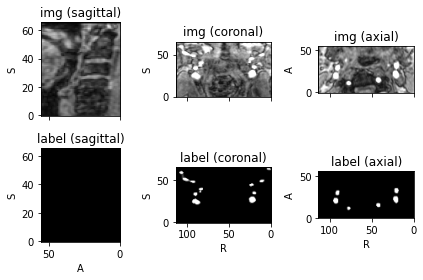

In [10]:
training_instance = training_set[11]  # transform is applied inside SubjectsDataset
training_instance.plot()

In [11]:
# check data size
print('shape : ',training_instance['img'].shape, training_instance['label'].shape)
# check value
shape = training_instance['label'].shape
print(training_instance['img'].data[0,shape[1]//2,:,shape[3]//2])
print(training_instance['label'].data[0,shape[1]//2,:,shape[3]//2])

shape :  (1, 114, 56, 66) (1, 114, 56, 66)
tensor([ 1.1646e-01,  4.4831e-01,  4.3115e-01, -1.5722e-01, -5.9131e-01,
        -5.7080e-01, -5.0231e-01, -8.4127e-01, -1.3717e+00, -1.5793e+00,
        -1.4736e+00, -1.2727e+00, -1.0776e+00, -9.1143e-01, -8.2551e-01,
        -8.7991e-01, -1.0498e+00, -1.1034e+00, -1.0460e+00, -1.1042e+00,
        -9.5788e-01, -8.0765e-01, -7.6623e-01, -4.9255e-01, -4.9185e-01,
        -3.7594e-01, -4.5485e-02, -2.3840e-01, -9.2772e-02,  4.8597e-01,
        -4.7578e-02, -1.0732e+00, -1.2833e+00, -1.2444e+00, -1.4059e+00,
        -1.4599e+00, -1.1116e+00, -5.6676e-01, -5.5978e-01, -9.7239e-01,
        -1.1904e+00, -1.0092e+00, -6.3706e-01, -1.8177e-01,  3.3155e-01,
         5.6087e-01,  3.8986e-01,  4.0335e-03, -2.1929e-01, -1.4355e-01,
        -5.6967e-04, -1.1868e-02, -5.3576e-02, -1.2566e-02,  8.8006e-02,
         2.1480e-01])
tensor([-0.1648, -0.1648, -0.1648, -0.1648, -0.1648, -0.1648, -0.1648, -0.1648,
        -0.1648, -0.1648, -0.1648, -0.1648, -0.1648,

## Patch sampling (use x)

In [12]:
training_batch_size = 16
validation_batch_size = 16

patch_size = 96
samples_per_volume = 30
max_queue_length = 30
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

## Train parameter

In [13]:
normalization = 'groupnorm'
num_epochs = 80
learning_rate = 0.001

## Model

In [14]:
EPS = 0.0001

class DiceLoss(Module):
    def forward(self, input, target):
        num=(input * target).sum(dim=4, keepdim=True).sum(dim=3, keepdim=True).sum(dim=2, keepdim=True)
        den1 = input.pow(2).sum(dim=4, keepdim=True).sum(dim=3, keepdim=True).sum(dim=2, keepdim=True)
        den2 = target.pow(2).sum(dim=4, keepdim=True).sum(dim=3, keepdim=True).sum(dim=2, keepdim=True)

        dice=(2.0 * num / (den1 + den2 + EPS))

        return (1.0 - dice).mean()

In [15]:
# multi-label
# def flatten(tensor):
#     """Flattens a given tensor such that the channel axis is first.
#     The shapes are transformed as follows:
#        (N, C, D, H, W) -> (C, N * D * H * W)
#     """
#     C = tensor.size(1)
#     # new axis order
#     axis_order = (1, 0) + tuple(range(2, tensor.dim()))
#     # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
#     transposed = tensor.permute(axis_order)
#     transposed.contiguous()
#     # Flatten: (C, N, D, H, W) ->
#     # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
#     return transposed.reshape(C, tensor.size(0)*tensor.size(2)*tensor.size(3)*tensor.size(4))


# class GeneralizedDiceLoss(Module):
#     """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf
#     """

#     def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True):
#         super(GeneralizedDiceLoss, self).__init__()
#         self.epsilon = epsilon
#         self.register_buffer('weight', weight)
#         self.ignore_index = ignore_index
#         if sigmoid_normalization:
#             self.normalization = nn.Sigmoid()
#         else:
#             self.normalization = nn.Softmax(dim=1)

#     def forward(self, input, target):
#         # get probabilities from logits
# #        input = self.normalization(input)

#         assert input.size() == target.size(), "'input' and 'target' must have the same shape"

#         # mask ignore_index if present
#         if self.ignore_index is not None:
#             mask = target.clone().ne_(self.ignore_index)
#             mask.requires_grad = False

#             input = input * mask
#             target = target * mask

#         target = flatten(target)
#         input = flatten(input)

#         target = target.float()
#         target_sum = target.sum(-1)
#         class_weights = Variable(1. / (target_sum * target_sum).clamp(min=self.epsilon), requires_grad=False)

#         intersect = (input * target).sum(-1) * class_weights
#         if self.weight is not None:
#             weight = Variable(self.weight, requires_grad=False)
#             intersect = weight * intersect

#         denominator = (input + target).sum(-1) * class_weights

#         return torch.mean(1. - 2. * intersect / denominator.clamp(min=self.epsilon))   

In [16]:
class GroupNorm3D(Module):
    def __init__(self, num_features, num_groups=16, eps=1e-5):
        super(GroupNorm3D, self).__init__()
        self.weight = Parameter(torch.ones(1, num_features, 1, 1, 1))
        self.bias = Parameter(torch.zeros(1, num_features, 1, 1, 1))
        self.num_groups = num_groups
        self.eps = eps

    def forward(self, x):
        N, C, H, W, D = x.size()
        G = self.num_groups
        assert C % G == 0

        x = x.view(N, G, -1)
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        x = (x-mean) / (var+self.eps).sqrt()
        x = x.view(N, C, H, W, D)
        return x * self.weight + self.bias

In [17]:
class ResidualConvBlock(nn.Module):
    def __init__(self, n_stages, n_filters_in, n_filters_out, normalization='none', expand_chan=False):
        super(ResidualConvBlock, self).__init__()

        self.expand_chan = expand_chan
        if self.expand_chan:
            ops = []

            ops.append(nn.Conv3d(n_filters_in, n_filters_out, 1))

            if normalization == 'batchnorm':
                ops.append(nn.BatchNorm3d(n_filters_out))
            if normalization == 'groupnorm':
                ops.append(GroupNorm3D(n_filters_out))
                
            #ops.append(nn.Dropout3d(p=0.5,inplace=False))

            ops.append(nn.ReLU(inplace=True))
            

            self.conv_expan = nn.Sequential(*ops)

        ops = []
        for i in range(n_stages):
            if normalization != 'none':
                ops.append(nn.Conv3d(n_filters_in, n_filters_out, 3, padding=1))
                if normalization == 'batchnorm':
                    ops.append(nn.BatchNorm3d(n_filters_out))
                if normalization == 'groupnorm':
                    ops.append(GroupNorm3D(n_filters_out))
            else:
                ops.append(nn.Conv3d(n_filters_in, n_filters_out, 3, padding=1))
            
            #ops.append(nn.Dropout3d(p=0.5,inplace=False))
            ops.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*ops)

    def forward(self, x):
        if self.expand_chan:
            x = self.conv(x) + self.conv_expan(x)
        else:
            x = (self.conv(x) + x)
        return x

In [18]:
class DownsamplingConvBlock(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, stride=2, normalization='none'):
        super(DownsamplingConvBlock, self).__init__()

        ops = []
        if normalization != 'none':
            ops.append(nn.Conv3d(n_filters_in, n_filters_out, stride, padding=0, stride=stride))
            if normalization == 'batchnorm':
                ops.append(nn.BatchNorm3d(n_filters_out))
            if normalization == 'groupnorm':
                ops.append(GroupNorm3D(n_filters_out))
        else:
            ops.append(nn.Conv3d(n_filters_in, n_filters_out, stride, padding=0, stride=stride))
        #ops.append(nn.Dropout3d(p=0.5,inplace=False))
        ops.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*ops)
    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
class UpsamplingDeconvBlock(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, stride=2, normalization='none'):
        super(UpsamplingDeconvBlock, self).__init__()

        ops = []
        if normalization != 'none':
            ops.append(nn.ConvTranspose3d(n_filters_in, n_filters_out, stride, padding=0, stride=stride))
            if normalization == 'batchnorm':
                ops.append(nn.BatchNorm3d(n_filters_out))
            if normalization == 'groupnorm':
                ops.append(GroupNorm3D(n_filters_out))
        else:
            ops.append(nn.ConvTranspose3d(n_filters_in, n_filters_out, stride, padding=0, stride=stride))
        #ops.append(nn.Dropout3d(p=0.5,inplace=False))
        ops.append(nn.ReLU(inplace=True))

        self.conv = nn.Sequential(*ops)
    def forward(self, x):
        x = self.conv(x)
        return x

In [20]:
class VNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters=16, normalization='none'):
        super(VNet, self).__init__()

        if n_channels > 1:
            self.block_one = ResidualConvBlock(1, n_channels, n_filters, normalization=normalization)
        else:
            self.block_one = ResidualConvBlock(1, n_channels, n_filters, normalization=normalization)
            self.block_one_dw = DownsamplingConvBlock(n_filters, 2 * n_filters, normalization=normalization)
            self.block_two = ResidualConvBlock(2, n_filters * 2, n_filters * 2, normalization=normalization)
            self.block_two_dw = DownsamplingConvBlock(n_filters * 2, n_filters * 4, normalization=normalization)
            self.block_three = ResidualConvBlock(3, n_filters * 4, n_filters * 4, normalization=normalization)
            self.block_three_dw = DownsamplingConvBlock(n_filters * 4, n_filters * 8, normalization=normalization)
            self.block_four = ResidualConvBlock(3, n_filters * 8, n_filters * 8, normalization=normalization)
            self.block_four_dw = DownsamplingConvBlock(n_filters * 8, n_filters * 16, normalization=normalization)
            self.block_five = ResidualConvBlock(3, n_filters * 16, n_filters * 16, normalization=normalization)
            self.block_five_up = UpsamplingDeconvBlock(n_filters * 16, n_filters * 8, normalization=normalization)
            self.block_six = ResidualConvBlock(3, n_filters * 8, n_filters * 8, normalization=normalization)
            self.block_six_up = UpsamplingDeconvBlock(n_filters * 8, n_filters * 4, normalization=normalization)
            self.block_seven = ResidualConvBlock(3, n_filters * 4, n_filters * 4, normalization=normalization)
            self.block_seven_up = UpsamplingDeconvBlock(n_filters * 4, n_filters * 2, normalization=normalization)
            self.block_eight = ResidualConvBlock(2, n_filters * 2, n_filters * 2, normalization=normalization)
            self.block_eight_up = UpsamplingDeconvBlock(n_filters * 2, n_filters, normalization=normalization)
            self.block_nine = ResidualConvBlock(1, n_filters, n_filters, normalization=normalization)
            self.out_conv = nn.Conv3d(n_filters, n_classes, 1, padding=0)
    def forward(self, input):
        x1 = self.block_one(input)
        x1_dw = self.block_one_dw(x1)
        x2 = self.block_two(x1_dw)
        x2_dw = self.block_two_dw(x2)
        x3 = self.block_three(x2_dw)
        x3_dw = self.block_three_dw(x3)
        x4 = self.block_four(x3_dw)
        x4_dw = self.block_four_dw(x4)
        x5 = self.block_five(x4_dw)
        x5_up = self.block_five_up(x5)
        x5_up = x5_up + x4
        x6 = self.block_six(x5_up)
        x6_up = self.block_six_up(x6)
        x6_up = x6_up + x3
        x7 = self.block_seven(x6_up)
        x7_up = self.block_seven_up(x7)
        x7_up = x7_up + x2
        x8 = self.block_eight(x7_up)
        x8_up = self.block_eight_up(x8)
        x8_up = x8_up + x1
        x9 = self.block_nine(x8_up)
        out = self.out_conv(x9)

        return out


In [21]:
net_seg = VNet(n_channels=1, n_classes=8, n_filters=16, normalization=normalization)
net_seg = torch.nn.DataParallel(net_seg)
net_seg.cuda()

DataParallel(
  (module): VNet(
    (block_one): ResidualConvBlock(
      (conv): Sequential(
        (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm3D()
        (2): ReLU(inplace=True)
      )
    )
    (block_one_dw): DownsamplingConvBlock(
      (conv): Sequential(
        (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
        (1): GroupNorm3D()
        (2): ReLU(inplace=True)
      )
    )
    (block_two): ResidualConvBlock(
      (conv): Sequential(
        (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm3D()
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm3D()
        (5): ReLU(inplace=True)
      )
    )
    (block_two_dw): DownsamplingConvBlock(
      (conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
        (1): GroupNorm3D()


## TRAIN

In [22]:
optimizer_seg = optim.Adam(net_seg.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()

In [28]:
#2.1.1
def run_training(net_seg):
    optimizer_seg = optim.Adam(net_seg.parameters(), lr=0.001)
    criterion_seg = DiceLoss()
#     criterion_seg = GeneralizedDiceLoss()

    running_seg_loss = 0.0
    
    patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
    )
    
    training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

    for i, data in enumerate(training_loader_patches, 0):
        
        inputs, labels = data['img']['data'], data['label']['data']
#         l1=(labels==1)
#         l2=(labels==2)
#         l3=(labels==3)
#         l4=(labels==4)
#         l5=(labels==5)
#         l6=(labels==0)
#         labels = torch.cat((l1,l2,l3,l4,l5,l6),1)
        

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
        loss_seg = criterion_seg(outputs_seg, labels)

        loss_seg.backward()
        optimizer_seg.step()
        

        
        gc.collect() #2.1.1 activate
        torch.cuda.empty_cache()

        running_seg_loss += loss_seg.detach().cpu().item()
    avg_loss = running_seg_loss / len(training_loader_patches)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
      #2.1.1  
#     del patches_training_set
#     del training_loader_patches
    
    return avg_loss, one_output_seg, one_output_img, one_output_lbl

In [24]:
# #2.1
# def run_training(net_seg):
# #    optimizer_seg = optim.Adam(net_seg.parameters(), lr=0.001)
# #    criterion_seg = DiceLoss()
# #    criterion_seg = GeneralizedDiceLoss()

#     running_seg_loss = 0.0
    
#     patches_training_set = tio.Queue(
#     subjects_dataset=training_set,
#     max_length=max_queue_length,
#     samples_per_volume=samples_per_volume,
#     sampler=sampler,
#     num_workers=num_workers,
#     shuffle_subjects=True,
#     shuffle_patches=True,
#     )
    
#     training_loader_patches = torch.utils.data.DataLoader(
#     patches_training_set, batch_size=training_batch_size)

#     for i, data in enumerate(training_loader_patches, 0):
        
#         inputs, labels = data['img']['data'], data['label']['data']
# #         l1=(labels==1)
# #         l2=(labels==2)
# #         l3=(labels==3)
# #         l4=(labels==4)
# #         l5=(labels==5)
# #         l6=(labels==0)
# #         labels = torch.cat((l1,l2,l3,l4,l5,l6),1)
        

#         if torch.cuda.is_available:
#             inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

#         inputs, labels = Variable(inputs), Variable(labels)
# #         if (i % effective_batchsize) == 0:
#         optimizer_seg.zero_grad()
        
#         net_seg.train()
#         outputs_seg = net_seg(inputs)

#         outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         loss_seg = criterion_seg(outputs_seg, labels)

#         loss_seg.backward()
#         optimizer_seg.step()
        

        
#         #gc.collect()
#         torch.cuda.empty_cache()

#         running_seg_loss += loss_seg.detach().cpu().item()
#     avg_loss = running_seg_loss / len(training_loader_patches)
#     one_output_seg = outputs_seg.detach().cpu().numpy()[0]
#     one_output_img = inputs.detach().cpu().numpy()[0]
#     one_output_lbl = labels.detach().cpu().numpy()[0]
    
#     del patches_training_set
#     del training_loader_patches
    
#     return avg_loss, one_output_seg, one_output_img, one_output_lbl

In [25]:
patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)


validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size, shuffle=False) 

In [26]:
def run_validation(net_seg):
    net_seg.eval()
    criterion_seg = DiceLoss()
#     criterion_seg = GeneralizedDiceLoss()    
  
    running_seg_loss = 0.0
    total_output_seg=[]
    total_output_img=[]
    
#     patches_validation_set = tio.Queue(
#         subjects_dataset=validation_set,
#         max_length=max_queue_length,
#         samples_per_volume=samples_per_volume,
#         sampler=sampler,
#         num_workers=num_workers,
#         shuffle_subjects=False,
#         shuffle_patches=False,
#     )


#     validation_loader_patches = torch.utils.data.DataLoader(
#         patches_validation_set, batch_size=validation_batch_size)  

  
    

    with torch.no_grad():
        for i, data in enumerate(validation_loader_patches, 0):
            inputs, labels = data['img']['data'], data['label']['data']
           
                    
#             l1=(labels==1)
#             l2=(labels==2)
#             l3=(labels==3)
#             l4=(labels==4)
#             l5=(labels==5)
#             l6=(labels==0)
#             labels = torch.cat((l1,l2,l3,l4,l5,l6),1)
        
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            
            loss_seg = criterion_seg(outputs_seg, labels)
            running_seg_loss += loss_seg.detach().cpu().item()
    avg_loss = running_seg_loss / len(validation_loader_patches)
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]

    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [27]:
#(2.1) - random seed=311, gc.collect(deactivate), batch size=16
train_losses = []
validation_losses = []
S = 60
# save_path = '/home/minyoung/SEGMENTATION/23.02.22/model_backup/02.24(2.1)'
start_time = time.time()


print('STARTING TRAINING')

for i in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('EPOCH {} of {}'.format(i, num_epochs))
    print('-- train loss {} -- valid loss {} --'.format(train_loss, valid_loss))
    print('-----run time {}sec -----'.format(time.time()-start_time))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
        
    if i%5==0:
        
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],
                                              train_input_lbl[1,:,:,S],train_input_lbl[2,:,:,S],
                                              train_input_lbl[3,:,:,S],train_input_lbl[4,:,:,S],train_input_lbl[5,:,:,S],
                                             train_input_lbl[6,:,:,S],train_input_lbl[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],
                                              train_seg_part[1,:,:,S],train_seg_part[2,:,:,S],
                                              train_seg_part[3,:,:,S],train_seg_part[4,:,:,S],train_seg_part[5,:,:,S],
                                             train_seg_part[6,:,:,S],train_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],
                                              valid_input_lbl_part[1,:,:,S],valid_input_lbl_part[2,:,:,S],
                                              valid_input_lbl_part[3,:,:,S],valid_input_lbl_part[4,:,:,S],valid_input_lbl_part[5,:,:,S],
                                             valid_input_lbl_part[6,:,:,S],valid_input_lbl_part[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],
                                              valid_output_seg_part[1,:,:,S],valid_output_seg_part[2,:,:,S],
                                              valid_output_seg_part[3,:,:,S],valid_output_seg_part[4,:,:,S],valid_output_seg_part[5,:,:,S],
                                             valid_output_seg_part[6,:,:,S],valid_output_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        
        plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
        #torch.save(net_seg,'vnet_ct_training_epoch='+str(i))
    path = os.path.join(save_path, 'vnet_epoch='+str(i))
#     torch.save(net_seg,path)

STARTING TRAINING


NameError: name 'GeneralizedDiceLoss' is not defined

STARTING TRAINING
EPOCH 0 of 80
-- train loss 0.9005569873032746 -- valid loss 0.7827894372098586 --
-----run time 831.8522098064423sec -----
Train


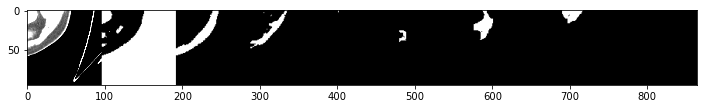

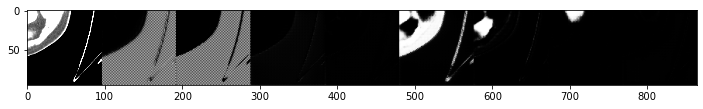

Valid


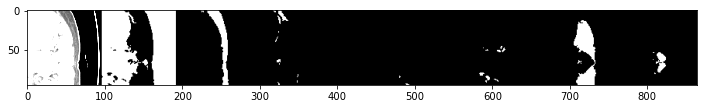

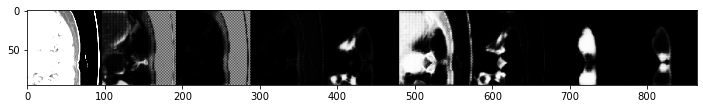

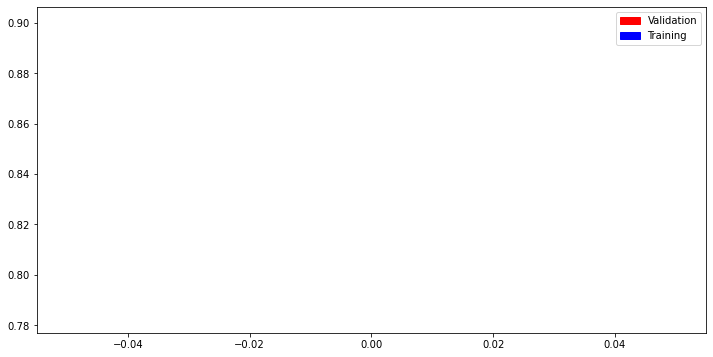

EPOCH 1 of 80
-- train loss 0.7480676191824454 -- valid loss 0.7121738966773538 --
-----run time 1698.9907162189484sec -----
EPOCH 2 of 80
-- train loss 0.7012789629123829 -- valid loss 0.6895382860127617 --
-----run time 2558.0467822551727sec -----
EPOCH 3 of 80
-- train loss 0.6806085284109469 -- valid loss 0.6467700539266362 --
-----run time 3362.983222961426sec -----
EPOCH 4 of 80
-- train loss 0.6695549892054664 -- valid loss 0.6458262450554791 --
-----run time 4209.468370437622sec -----
EPOCH 5 of 80
-- train loss 0.6637419060424522 -- valid loss 0.649121855988222 --
-----run time 5044.125942707062sec -----
Train


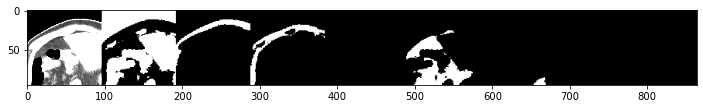

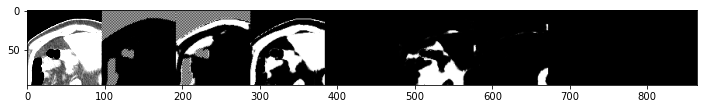

Valid


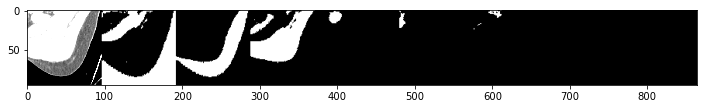

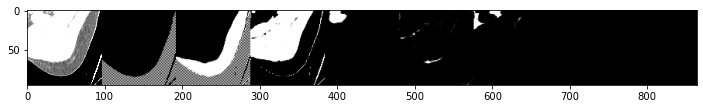

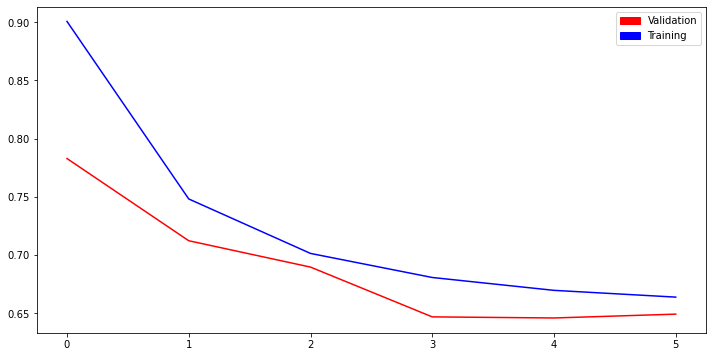

EPOCH 6 of 80
-- train loss 0.6624399189595823 -- valid loss 0.640670582652092 --
-----run time 5872.819973707199sec -----
EPOCH 7 of 80
-- train loss 0.6594178727379552 -- valid loss 0.6376399757230983 --
-----run time 6711.250604629517sec -----
EPOCH 8 of 80
-- train loss 0.6581095289300989 -- valid loss 0.6349304774228264 --
-----run time 7535.736936807632sec -----
EPOCH 9 of 80
-- train loss 0.6531940669925125 -- valid loss 0.6314535938641604 --
-----run time 8382.075994968414sec -----
EPOCH 10 of 80
-- train loss 0.6551004687945048 -- valid loss 0.6264569040607003 --
-----run time 9196.07002401352sec -----
Train


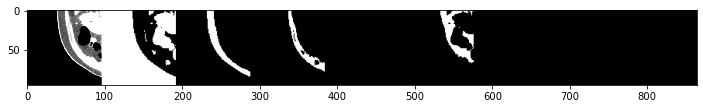

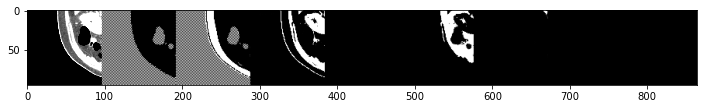

Valid


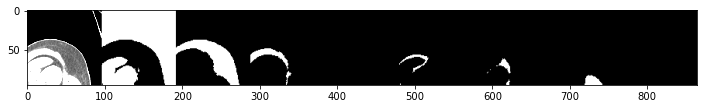

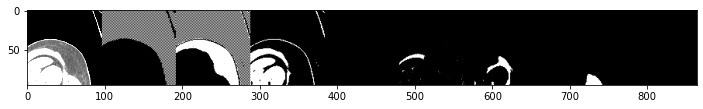

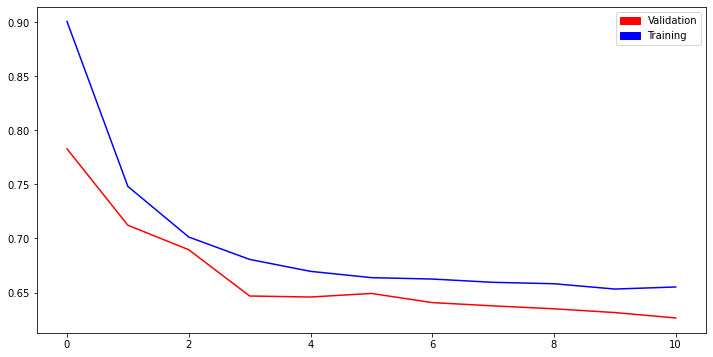

EPOCH 11 of 80
-- train loss 0.6549269587905319 -- valid loss 0.6323115930837744 --
-----run time 10041.667826414108sec -----
EPOCH 12 of 80
-- train loss 0.6493649970602107 -- valid loss 0.6388221900252735 --
-----run time 10850.079458236694sec -----
EPOCH 13 of 80
-- train loss 0.6474924008051555 -- valid loss 0.624546468257904 --
-----run time 11715.154382228851sec -----
EPOCH 14 of 80
-- train loss 0.649840705593427 -- valid loss 0.6254798572729615 --
-----run time 12570.397667169571sec -----
EPOCH 15 of 80
-- train loss 0.6455981245747319 -- valid loss 0.6253514850840849 --
-----run time 13414.142811536789sec -----
Train


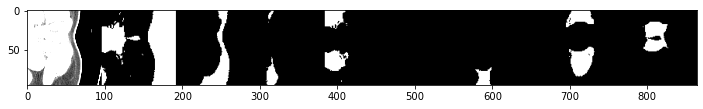

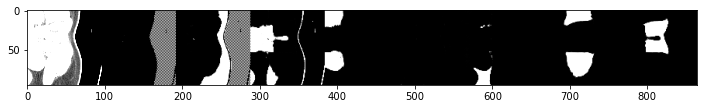

Valid


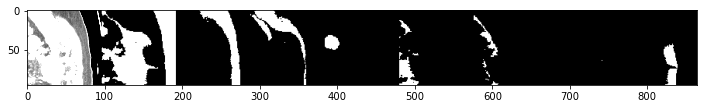

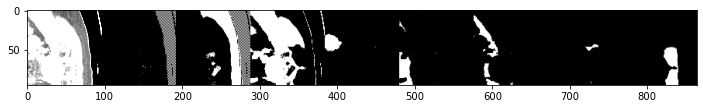

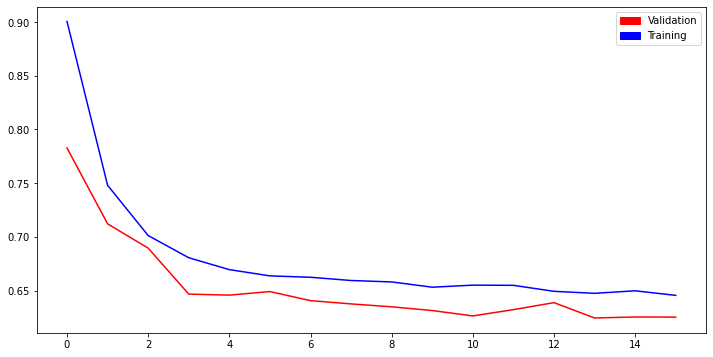

EPOCH 16 of 80
-- train loss 0.6475008754818528 -- valid loss 0.6306377789553474 --
-----run time 14230.744760990143sec -----
EPOCH 17 of 80
-- train loss 0.646964818680728 -- valid loss 0.626220682526336 --
-----run time 15075.733850240707sec -----
EPOCH 18 of 80
-- train loss 0.6444521636874587 -- valid loss 0.6165904328227043 --
-----run time 15927.74159169197sec -----
EPOCH 19 of 80
-- train loss 0.6429693034401647 -- valid loss 0.6167250919867965 --
-----run time 16788.166656255722sec -----
EPOCH 20 of 80
-- train loss 0.6417629462701303 -- valid loss 0.6283078947487999 --
-----run time 17612.762679815292sec -----
Train


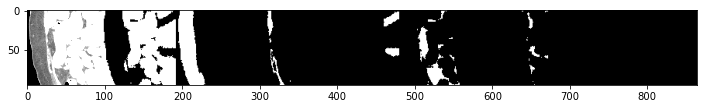

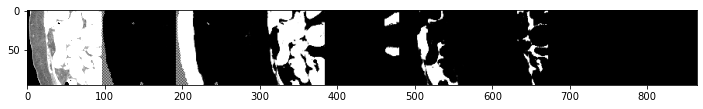

Valid


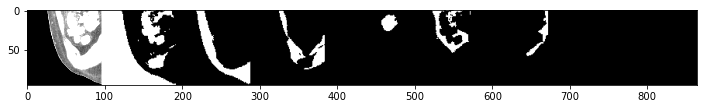

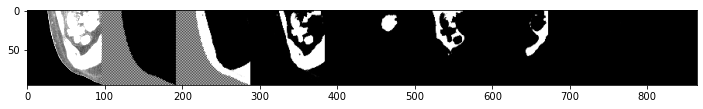

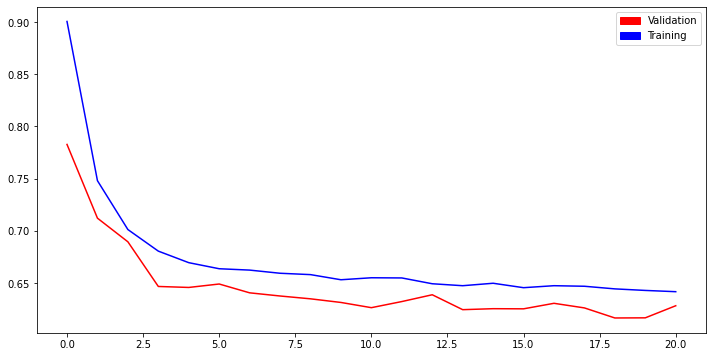

EPOCH 21 of 80
-- train loss 0.6451838772605967 -- valid loss 0.625744207378696 --
-----run time 18451.52295446396sec -----
EPOCH 22 of 80
-- train loss 0.6411272493777451 -- valid loss 0.6144175634664648 --
-----run time 19296.44446706772sec -----
EPOCH 23 of 80
-- train loss 0.6430267773292683 -- valid loss 0.6245340047513738 --
-----run time 20161.02451133728sec -----
EPOCH 24 of 80
-- train loss 0.6371020451739983 -- valid loss 0.6235195670057746 --
-----run time 20972.014966487885sec -----
EPOCH 25 of 80
-- train loss 0.6411293241712782 -- valid loss 0.6234791646985447 --
-----run time 21827.384041547775sec -----
Train


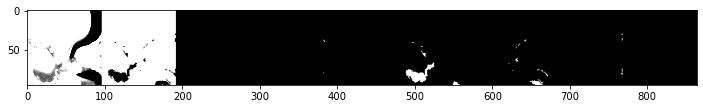

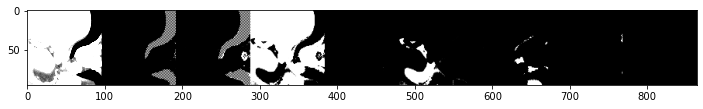

Valid


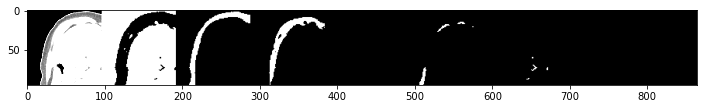

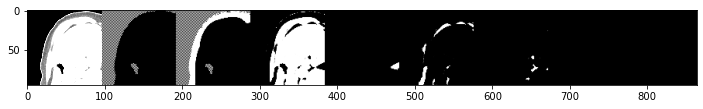

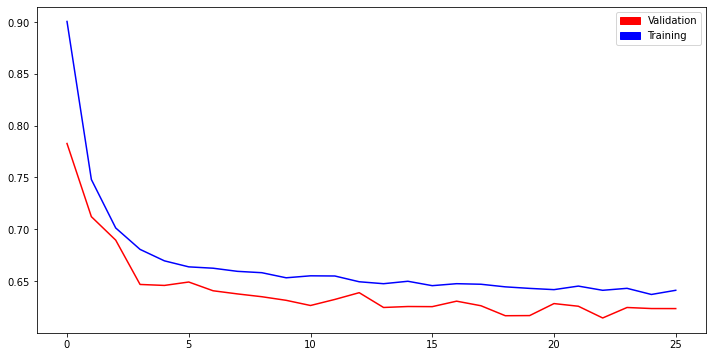

EPOCH 26 of 80
-- train loss 0.6389697459008958 -- valid loss 0.6221812976633802 --
-----run time 22671.603331804276sec -----
EPOCH 27 of 80
-- train loss 0.6435077214682544 -- valid loss 0.6258211635491427 --
-----run time 23528.738201379776sec -----
EPOCH 28 of 80
-- train loss 0.6347721539161824 -- valid loss 0.6269680695498691 --
-----run time 24366.6998193264sec -----
EPOCH 29 of 80
-- train loss 0.63691599269708 -- valid loss 0.612316167968161 --
-----run time 25239.890674114227sec -----
EPOCH 30 of 80
-- train loss 0.6410217835947319 -- valid loss 0.6210188716650009 --
-----run time 26053.269946336746sec -----
Train


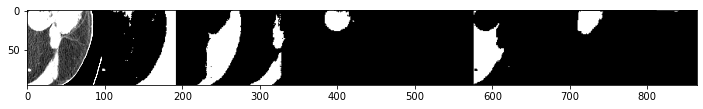

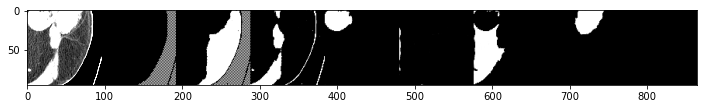

Valid


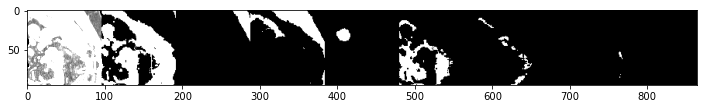

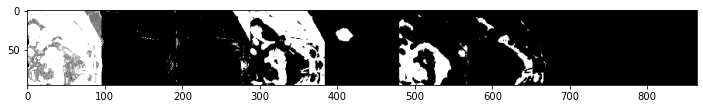

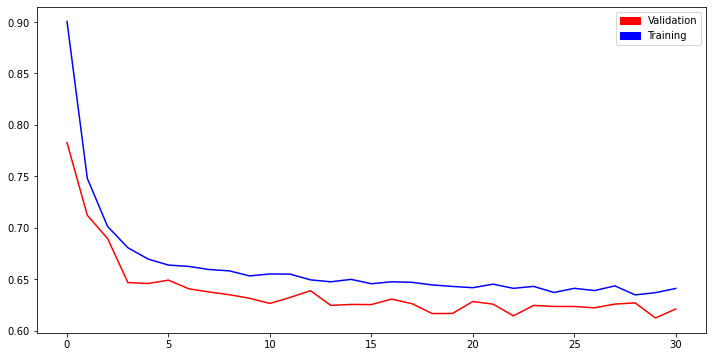

EPOCH 31 of 80
-- train loss 0.6389651196974295 -- valid loss 0.6241665929555893 --
-----run time 26910.441403865814sec -----
EPOCH 32 of 80
-- train loss 0.6424596418937047 -- valid loss 0.6213952219661545 --
-----run time 27729.77015900612sec -----
EPOCH 33 of 80
-- train loss 0.6328059401777055 -- valid loss 0.6067430543548921 --
-----run time 28576.59381723404sec -----
EPOCH 34 of 80
-- train loss 0.6410336235055217 -- valid loss 0.6177504693760592 --
-----run time 29400.308954954147sec -----
EPOCH 35 of 80
-- train loss 0.6388082991043726 -- valid loss 0.6179347134688321 --
-----run time 30263.20260810852sec -----
Train


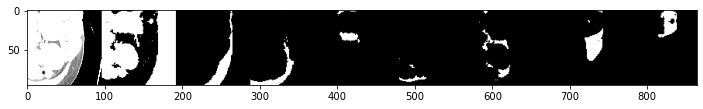

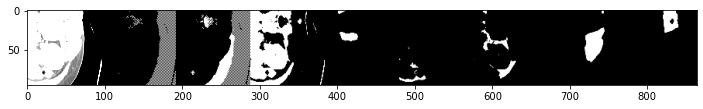

Valid


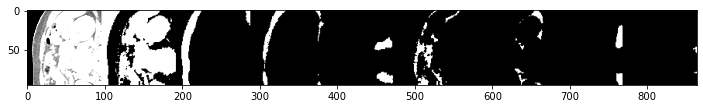

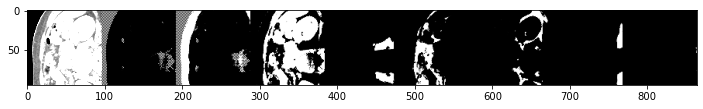

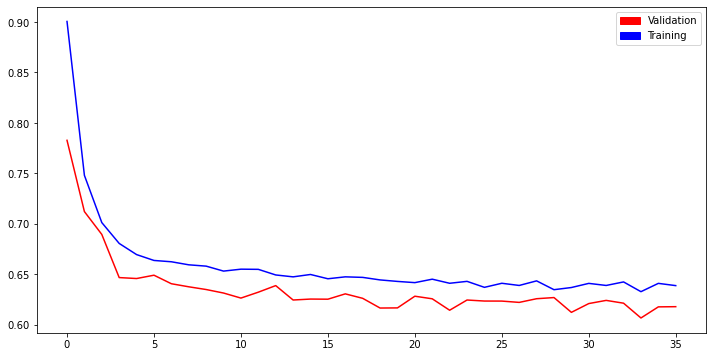

EPOCH 36 of 80
-- train loss 0.636826741805783 -- valid loss 0.6249175711589701 --
-----run time 31113.017714500427sec -----
EPOCH 37 of 80
-- train loss 0.6368152113976302 -- valid loss 0.6184834162978565 --
-----run time 31979.76759004593sec -----
EPOCH 38 of 80
-- train loss 0.6375532272789214 -- valid loss 0.6157596181420719 --
-----run time 32832.19946527481sec -----
EPOCH 39 of 80
-- train loss 0.6375716872789242 -- valid loss 0.6137490666964475 --
-----run time 33700.38563108444sec -----
EPOCH 40 of 80
-- train loss 0.6355170593217567 -- valid loss 0.6272619533188203 --
-----run time 34544.019498586655sec -----
Train


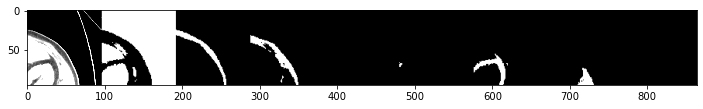

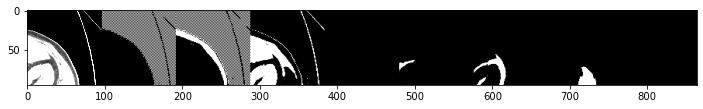

Valid


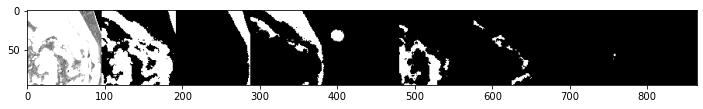

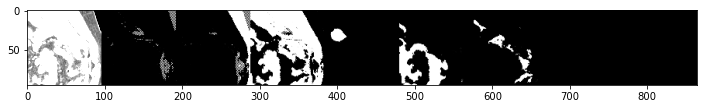

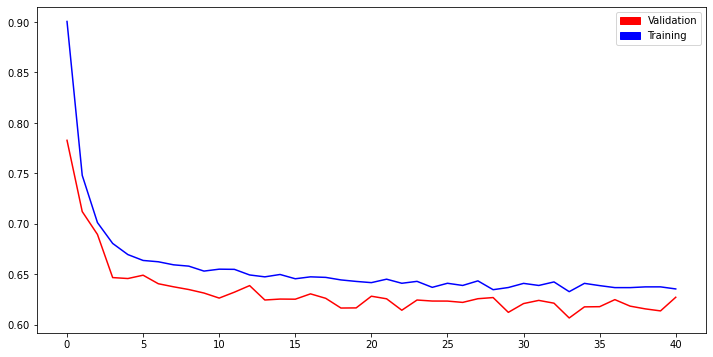

EPOCH 41 of 80
-- train loss 0.6399634349125403 -- valid loss 0.620450464241645 --
-----run time 35385.94187259674sec -----
EPOCH 42 of 80
-- train loss 0.6376875423722796 -- valid loss 0.6140905995579327 --
-----run time 36244.72828793526sec -----
EPOCH 43 of 80
-- train loss 0.6359160562356313 -- valid loss 0.6259781126590336 --
-----run time 37079.38359475136sec -----
EPOCH 44 of 80
-- train loss 0.6381165746185514 -- valid loss 0.6182961626087918 --
-----run time 37905.660937547684sec -----
EPOCH 45 of 80
-- train loss 0.6333544773084147 -- valid loss 0.6188517164658097 --
-----run time 38726.68860054016sec -----
Train


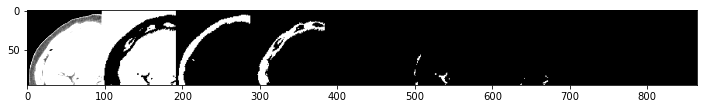

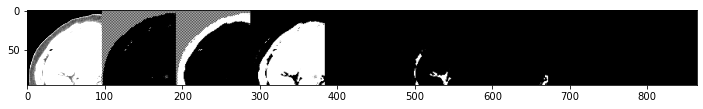

Valid


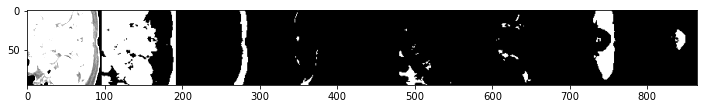

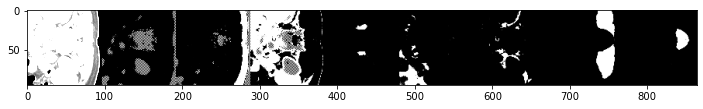

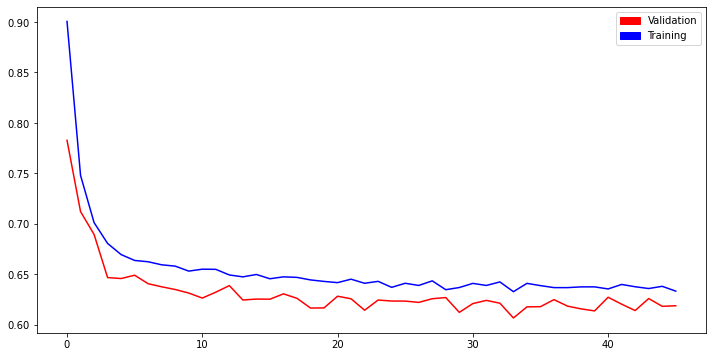

EPOCH 46 of 80
-- train loss 0.6329992636486336 -- valid loss 0.6160566556979629 --
-----run time 39545.48491883278sec -----
EPOCH 47 of 80
-- train loss 0.6336265928215451 -- valid loss 0.610108915497275 --
-----run time 40373.651324272156sec -----
EPOCH 48 of 80
-- train loss 0.6334907677438524 -- valid loss 0.6146761643535951 --
-----run time 41181.70778131485sec -----
EPOCH 49 of 80
-- train loss 0.635431937818174 -- valid loss 0.6105708672719843 --
-----run time 42039.05725121498sec -----
EPOCH 50 of 80
-- train loss 0.6326630544883234 -- valid loss 0.6268052480676595 --
-----run time 42853.782319545746sec -----
Train


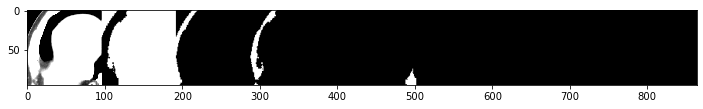

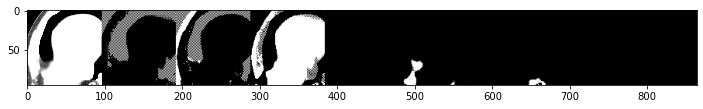

Valid


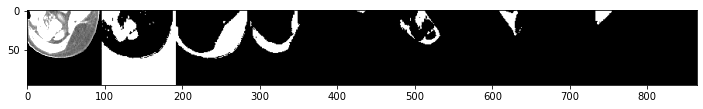

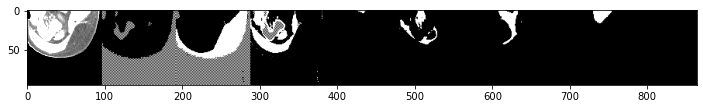

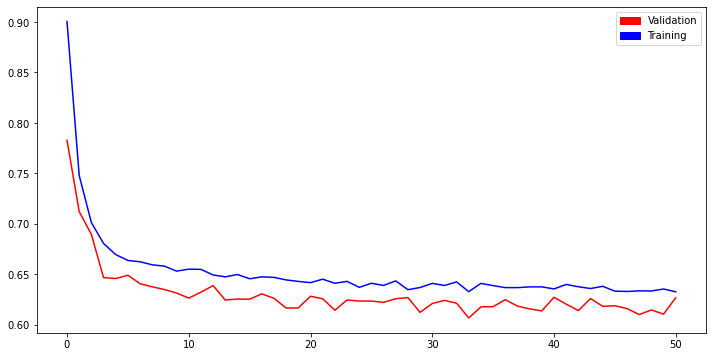

EPOCH 51 of 80
-- train loss 0.6296772851988122 -- valid loss 0.622749834376223 --
-----run time 43683.02484989166sec -----
EPOCH 52 of 80
-- train loss 0.6356533625611552 -- valid loss 0.6275417064042652 --
-----run time 44498.679040431976sec -----
EPOCH 53 of 80
-- train loss 0.6381477078905812 -- valid loss 0.6065886016277706 --
-----run time 45315.93158364296sec -----
EPOCH 54 of 80
-- train loss 0.6388630816230068 -- valid loss 0.6160865855567595 --
-----run time 46117.71451258659sec -----
EPOCH 55 of 80
-- train loss 0.6342713918950823 -- valid loss 0.607143273248392 --
-----run time 46957.0125002861sec -----
Train


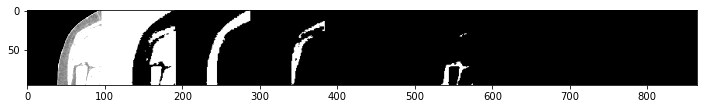

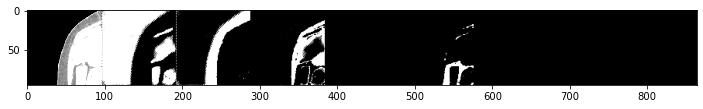

Valid


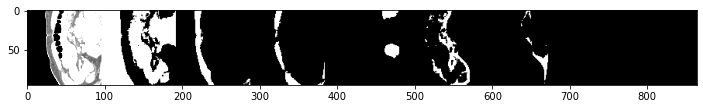

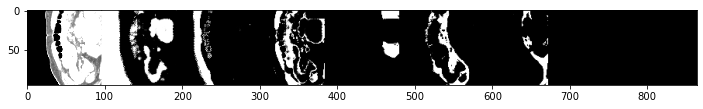

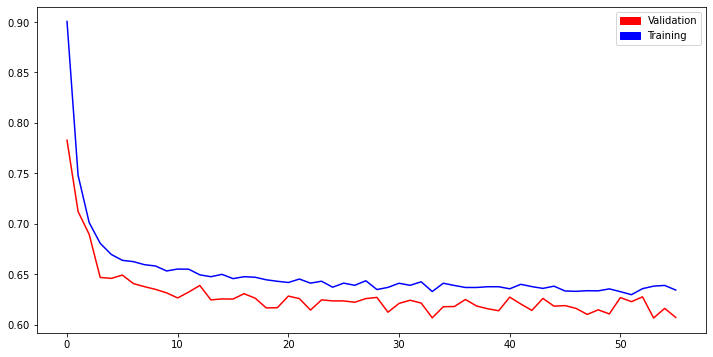

EPOCH 56 of 80
-- train loss 0.6360029399394989 -- valid loss 0.614231316920589 --
-----run time 47769.643626213074sec -----
EPOCH 57 of 80
-- train loss 0.6349817636940215 -- valid loss 0.6130701526999474 --
-----run time 48593.68732666969sec -----
EPOCH 58 of 80
-- train loss 0.6336311042308808 -- valid loss 0.6119719125768718 --
-----run time 49422.17813754082sec -----
EPOCH 59 of 80
-- train loss 0.6356735068338889 -- valid loss 0.618632056257304 --
-----run time 50254.9213013649sec -----
EPOCH 60 of 80
-- train loss 0.6301725625991821 -- valid loss 0.6154770184965694 --
-----run time 51060.72169613838sec -----
Train


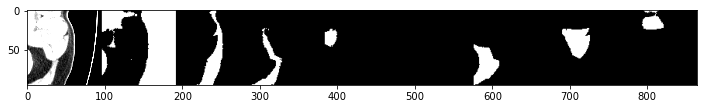

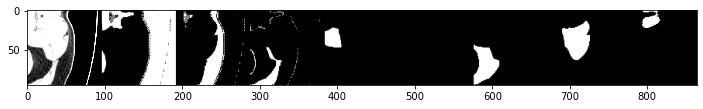

Valid


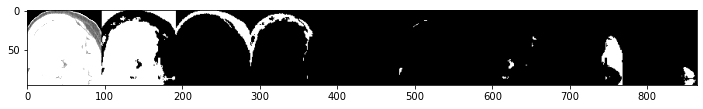

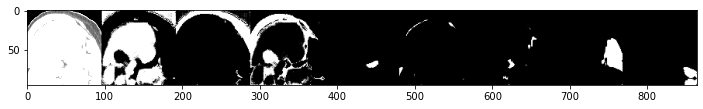

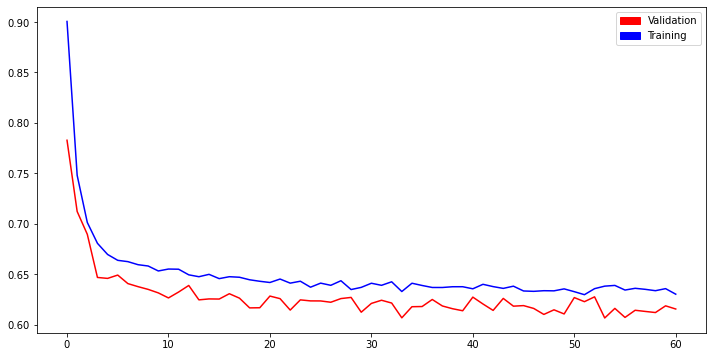

EPOCH 61 of 80
-- train loss 0.6284352098350172 -- valid loss 0.613979304976323 --
-----run time 51908.403067588806sec -----
EPOCH 62 of 80
-- train loss 0.6287969264719221 -- valid loss 0.6170229644459837 --
-----run time 52737.01818585396sec -----
EPOCH 63 of 80
-- train loss 0.6317203250196245 -- valid loss 0.6077826755011783 --
-----run time 53575.137561798096sec -----
EPOCH 64 of 80
-- train loss 0.6330270141363143 -- valid loss 0.6149274229126818 --
-----run time 54412.40937209129sec -----
EPOCH 65 of 80
-- train loss 0.6323929541640811 -- valid loss 0.6132763181539143 --
-----run time 55281.86154770851sec -----
Train


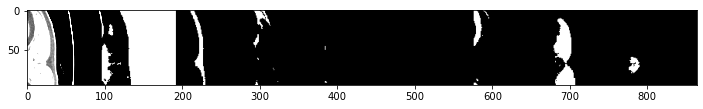

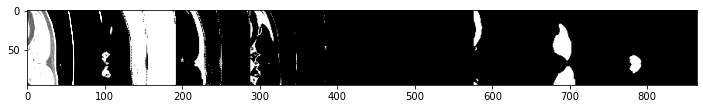

Valid


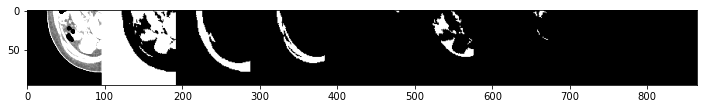

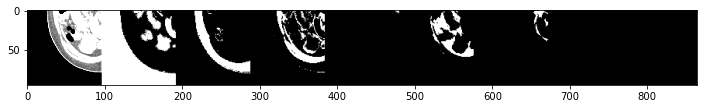

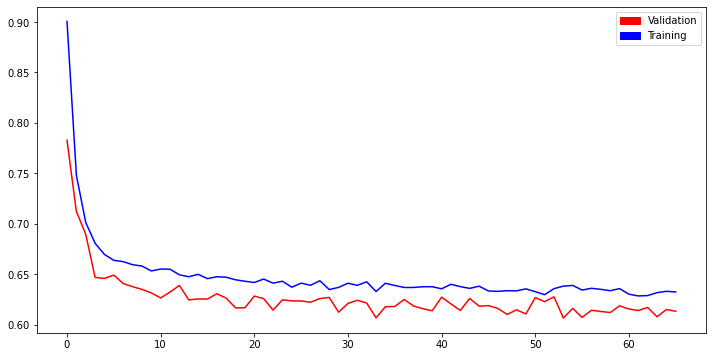

EPOCH 66 of 80
-- train loss 0.6296437969914189 -- valid loss 0.6075066385023734 --
-----run time 56100.89946770668sec -----
EPOCH 67 of 80
-- train loss 0.6330625617945635 -- valid loss 0.6106162632212919 --
-----run time 56979.06308031082sec -----
EPOCH 68 of 80
-- train loss 0.6292293239522864 -- valid loss 0.6147348863237044 --
-----run time 57799.84476709366sec -----
EPOCH 69 of 80
-- train loss 0.6278433200385836 -- valid loss 0.6101467083482182 --
-----run time 58631.22485160828sec -----
EPOCH 70 of 80
-- train loss 0.6301074284094351 -- valid loss 0.6209220947588191 --
-----run time 59463.42405581474sec -----
Train


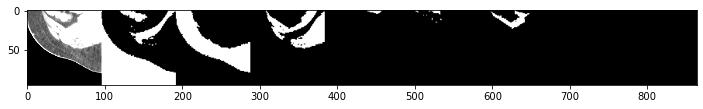

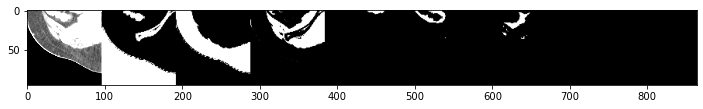

Valid


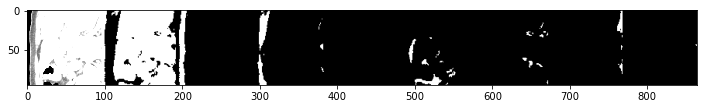

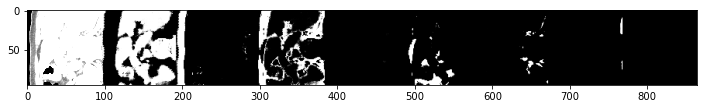

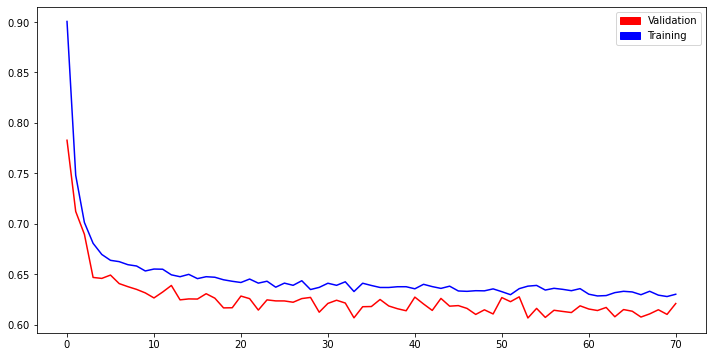

EPOCH 71 of 80
-- train loss 0.630443004877479 -- valid loss 0.6125672748860191 --
-----run time 60304.840502262115sec -----
EPOCH 72 of 80
-- train loss 0.6300606792723691 -- valid loss 0.6217649456332711 --
-----run time 61118.73537278175sec -----
EPOCH 73 of 80
-- train loss 0.6306495253686552 -- valid loss 0.6124807482256609 --
-----run time 61942.26330089569sec -----
EPOCH 74 of 80
-- train loss 0.6336616120956562 -- valid loss 0.6092052696382299 --
-----run time 62779.70679950714sec -----
EPOCH 75 of 80
-- train loss 0.627662330424344 -- valid loss 0.6178914575892336 --
-----run time 63635.23605251312sec -----
Train


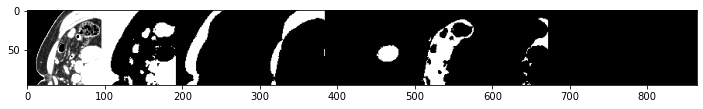

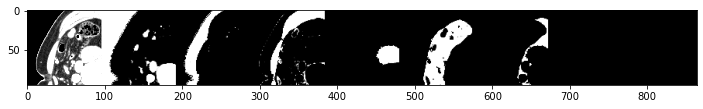

Valid


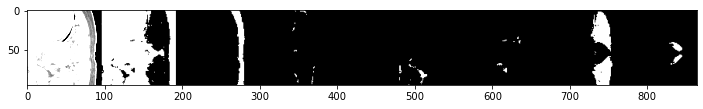

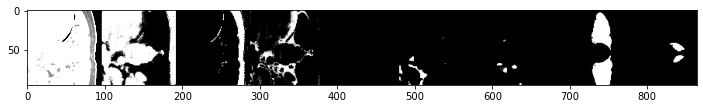

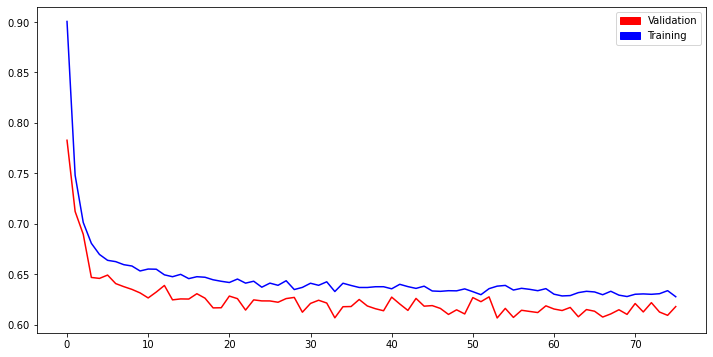

EPOCH 76 of 80
-- train loss 0.6310429878808834 -- valid loss 0.6118167989394244 --
-----run time 64462.340254068375sec -----
EPOCH 77 of 80
-- train loss 0.6303064660893546 -- valid loss 0.6121865230448106 --
-----run time 65308.36373567581sec -----
EPOCH 78 of 80
-- train loss 0.6327771703402202 -- valid loss 0.6082709436030949 --
-----run time 66141.77686882019sec -----
EPOCH 79 of 80
-- train loss 0.6329191446304321 -- valid loss 0.6141009041491676 --
-----run time 66982.57598662376sec -----


In [20]:
#(2.1.1) - random seed=551, gc.collect(activate), batch size=16
train_losses = []
validation_losses = []
S = 60
save_path = '/home/minyoung/SEGMENTATION/23.02.22/model_backup/02.24(2.1.1)'
start_time = time.time()


print('STARTING TRAINING')

for i in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('EPOCH {} of {}'.format(i, num_epochs))
    print('-- train loss {} -- valid loss {} --'.format(train_loss, valid_loss))
    print('-----run time {}sec -----'.format(time.time()-start_time))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
        
    if i%5==0:
        
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],
                                              train_input_lbl[1,:,:,S],train_input_lbl[2,:,:,S],
                                              train_input_lbl[3,:,:,S],train_input_lbl[4,:,:,S],train_input_lbl[5,:,:,S],
                                             train_input_lbl[6,:,:,S],train_input_lbl[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],
                                              train_seg_part[1,:,:,S],train_seg_part[2,:,:,S],
                                              train_seg_part[3,:,:,S],train_seg_part[4,:,:,S],train_seg_part[5,:,:,S],
                                             train_seg_part[6,:,:,S],train_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],
                                              valid_input_lbl_part[1,:,:,S],valid_input_lbl_part[2,:,:,S],
                                              valid_input_lbl_part[3,:,:,S],valid_input_lbl_part[4,:,:,S],valid_input_lbl_part[5,:,:,S],
                                             valid_input_lbl_part[6,:,:,S],valid_input_lbl_part[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],
                                              valid_output_seg_part[1,:,:,S],valid_output_seg_part[2,:,:,S],
                                              valid_output_seg_part[3,:,:,S],valid_output_seg_part[4,:,:,S],valid_output_seg_part[5,:,:,S],
                                             valid_output_seg_part[6,:,:,S],valid_output_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        
        plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
        #torch.save(net_seg,'vnet_ct_training_epoch='+str(i))
    path = os.path.join(save_path, 'vnet_epoch='+str(i))
    torch.save(net_seg,path)

STARTING TRAINING
EPOCH 0 of 80
-- train loss 0.8596555168981905 -- valid loss 0.7948034370646757 --
-----run time 1114.8109142780304sec -----
Train


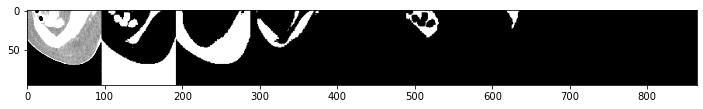

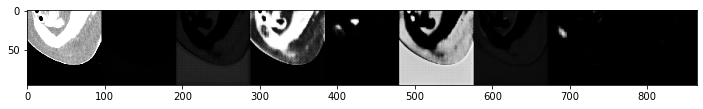

Valid


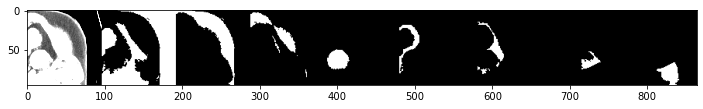

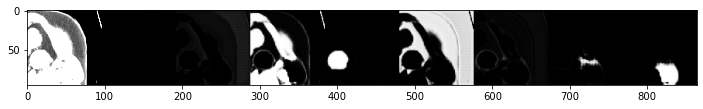

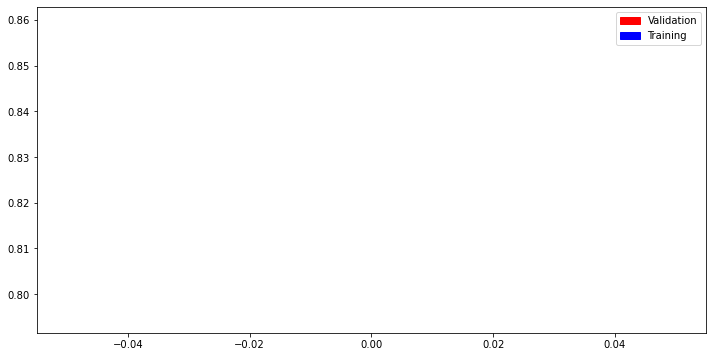

EPOCH 1 of 80
-- train loss 0.7451858262221018 -- valid loss 0.7165709234335843 --
-----run time 2208.168706178665sec -----
EPOCH 2 of 80
-- train loss 0.6956642704981345 -- valid loss 0.670867796329891 --
-----run time 3340.2041285037994sec -----
EPOCH 3 of 80
-- train loss 0.6784807549582588 -- valid loss 0.6632975129520192 --
-----run time 4490.242100477219sec -----
EPOCH 4 of 80
-- train loss 0.6707160472869873 -- valid loss 0.6578991018673953 --
-----run time 5671.902773141861sec -----
EPOCH 5 of 80
-- train loss 0.6660156585552074 -- valid loss 0.6567241444307215 --
-----run time 6808.93154501915sec -----
Train


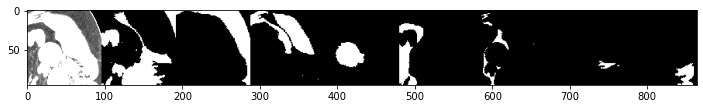

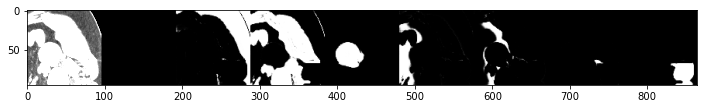

Valid


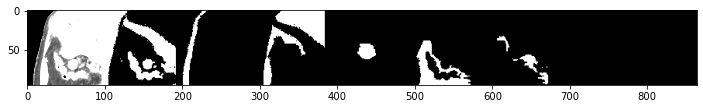

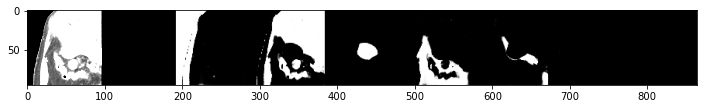

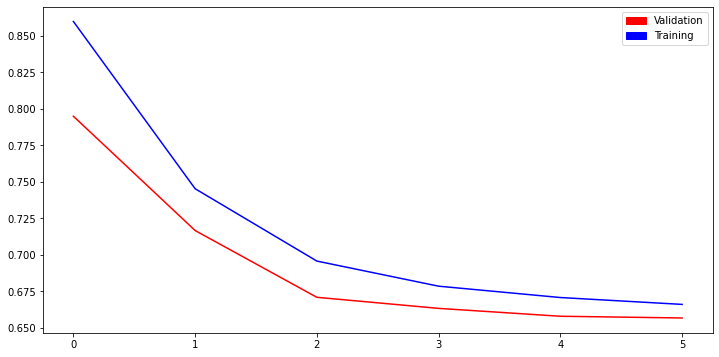

EPOCH 6 of 80
-- train loss 0.658608266821614 -- valid loss 0.6560753601438859 --
-----run time 8090.48868894577sec -----
EPOCH 7 of 80
-- train loss 0.6604924062887828 -- valid loss 0.6479278645094704 --
-----run time 9201.27084183693sec -----
EPOCH 8 of 80
-- train loss 0.6561016427146064 -- valid loss 0.6518825730856728 --
-----run time 10244.703503847122sec -----
EPOCH 9 of 80
-- train loss 0.6487123154931598 -- valid loss 0.6403067409992218 --
-----run time 11432.080772161484sec -----
EPOCH 10 of 80
-- train loss 0.6525038619836171 -- valid loss 0.6426005004083409 --
-----run time 12442.208837985992sec -----
Train


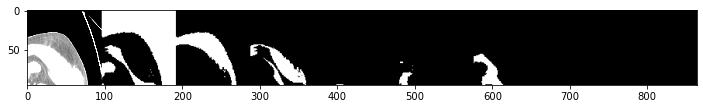

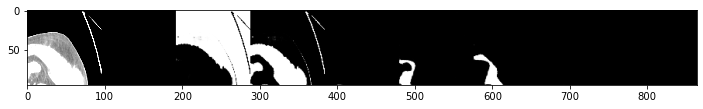

Valid


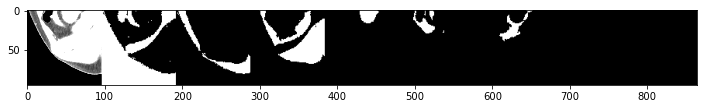

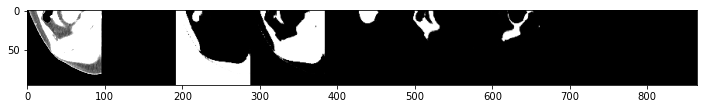

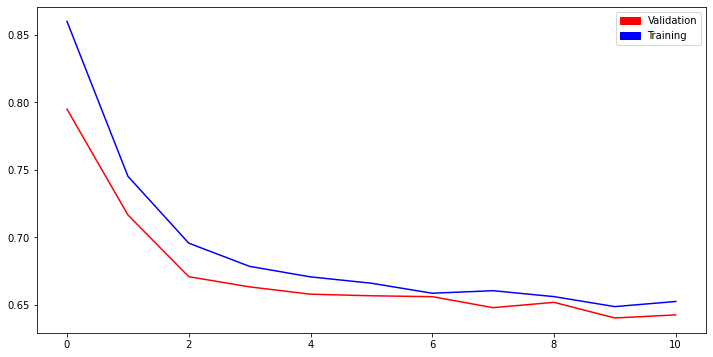

EPOCH 11 of 80
-- train loss 0.6469838046365314 -- valid loss 0.6440446070011925 --
-----run time 13565.973823547363sec -----
EPOCH 12 of 80
-- train loss 0.6482607077669215 -- valid loss 0.6469175789286109 --
-----run time 14726.861162424088sec -----
EPOCH 13 of 80
-- train loss 0.6495492908689711 -- valid loss 0.6344808094641742 --
-----run time 15813.07770395279sec -----
EPOCH 14 of 80
-- train loss 0.6425372034311294 -- valid loss 0.6424774772980634 --
-----run time 16946.018802165985sec -----
EPOCH 15 of 80
-- train loss 0.6463103564801039 -- valid loss 0.6438237402368995 --
-----run time 18102.780728578568sec -----
Train


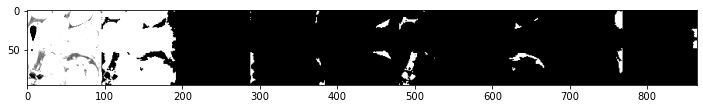

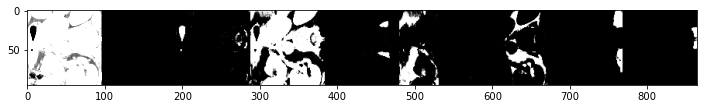

Valid


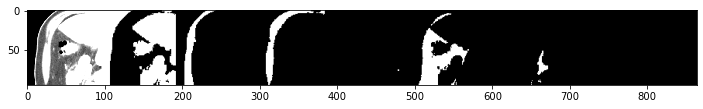

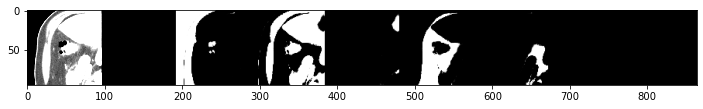

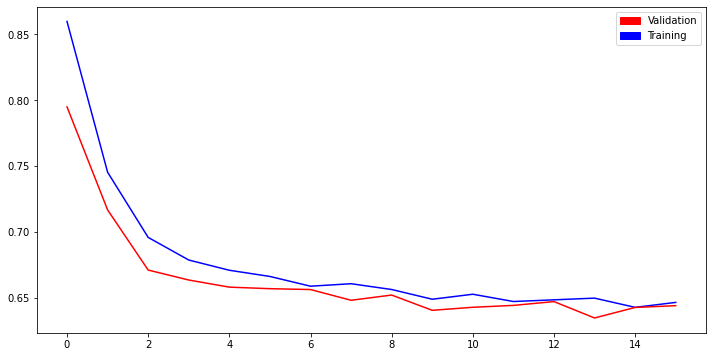

EPOCH 16 of 80
-- train loss 0.6467566355510994 -- valid loss 0.6400469059453291 --
-----run time 19228.69872736931sec -----
EPOCH 17 of 80
-- train loss 0.6464372173503593 -- valid loss 0.6450555473566055 --
-----run time 20354.090183019638sec -----
EPOCH 18 of 80
-- train loss 0.6409321197757014 -- valid loss 0.6406154334545135 --
-----run time 21419.684512615204sec -----
EPOCH 19 of 80
-- train loss 0.6425303974637279 -- valid loss 0.6315890936290517 --
-----run time 22496.58354306221sec -----
EPOCH 20 of 80
-- train loss 0.6370535553605469 -- valid loss 0.6329748367562014 --
-----run time 23639.78410243988sec -----
Train


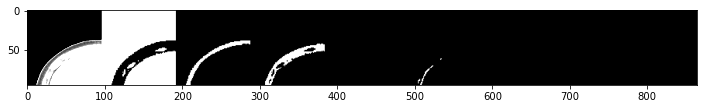

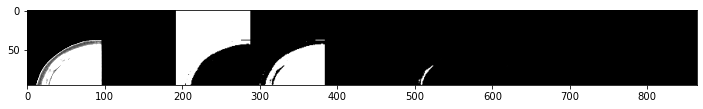

Valid


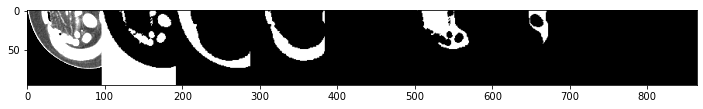

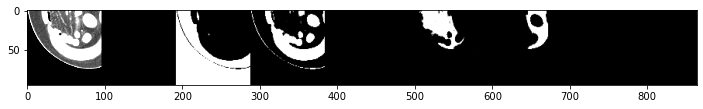

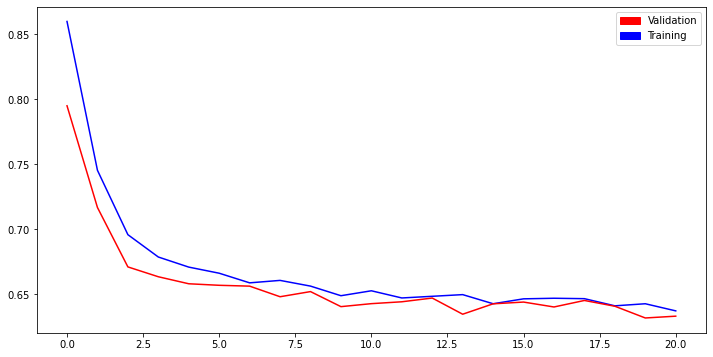

EPOCH 21 of 80
-- train loss 0.6320713141450176 -- valid loss 0.6333339836667565 --
-----run time 24675.21617412567sec -----
EPOCH 22 of 80
-- train loss 0.6330781487403092 -- valid loss 0.631299557054744 --
-----run time 25710.189348459244sec -----
EPOCH 23 of 80
-- train loss 0.6372815288879253 -- valid loss 0.6313556669389501 --
-----run time 26866.180634260178sec -----
EPOCH 24 of 80
-- train loss 0.6352387028711813 -- valid loss 0.6333498104530222 --
-----run time 27990.966165304184sec -----
EPOCH 25 of 80
-- train loss 0.6347475093823892 -- valid loss 0.6269497380537146 --
-----run time 29056.236058473587sec -----
Train


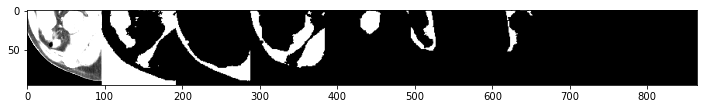

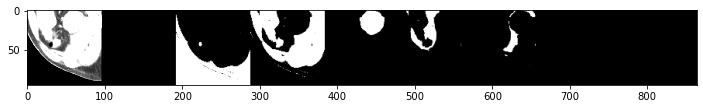

Valid


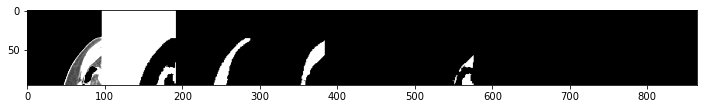

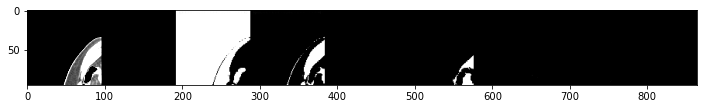

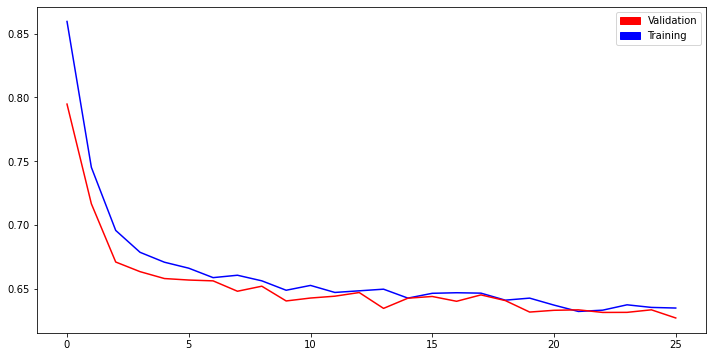

EPOCH 26 of 80
-- train loss 0.6350931702940552 -- valid loss 0.6324604197460062 --
-----run time 30158.785637378693sec -----
EPOCH 27 of 80
-- train loss 0.6349908524089389 -- valid loss 0.6318755062187419 --
-----run time 31278.104822158813sec -----
EPOCH 28 of 80
-- train loss 0.6345424364010493 -- valid loss 0.6332401151166243 --
-----run time 32532.603448867798sec -----
EPOCH 29 of 80
-- train loss 0.6396411539227874 -- valid loss 0.6316288744702059 --
-----run time 33669.77456617355sec -----
EPOCH 30 of 80
-- train loss 0.6341844714350171 -- valid loss 0.6241549744325525 --
-----run time 34851.72907447815sec -----
Train


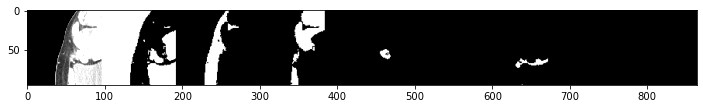

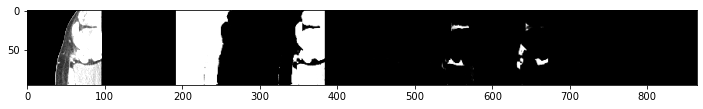

Valid


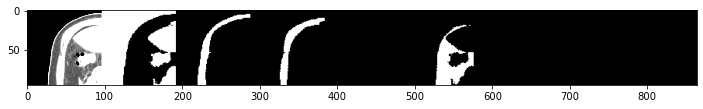

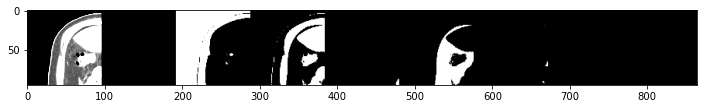

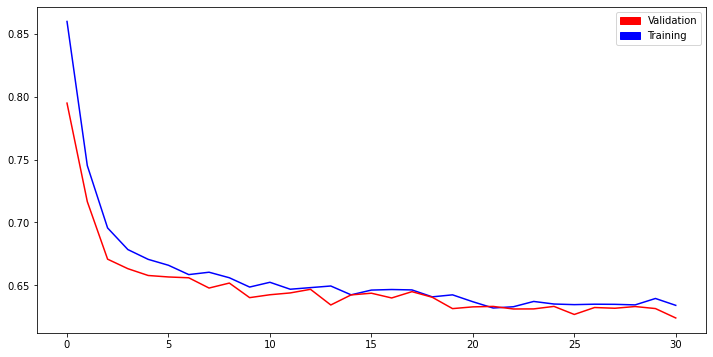

EPOCH 31 of 80
-- train loss 0.6337772476452368 -- valid loss 0.6325888554839527 --
-----run time 36015.24199271202sec -----
EPOCH 32 of 80
-- train loss 0.6344479556436892 -- valid loss 0.6286819691167158 --
-----run time 37104.82044816017sec -----
EPOCH 33 of 80
-- train loss 0.6350177605946858 -- valid loss 0.6277120310594054 --
-----run time 38257.14905667305sec -----
EPOCH 34 of 80
-- train loss 0.6319592003469114 -- valid loss 0.634308385060114 --
-----run time 39480.34444332123sec -----
EPOCH 35 of 80
-- train loss 0.6349094582928552 -- valid loss 0.633056702420992 --
-----run time 40538.97672200203sec -----
Train


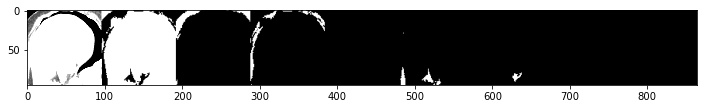

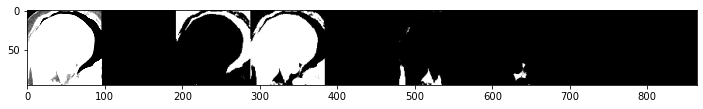

Valid


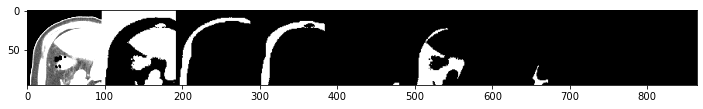

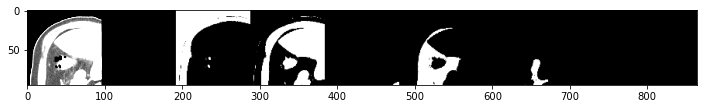

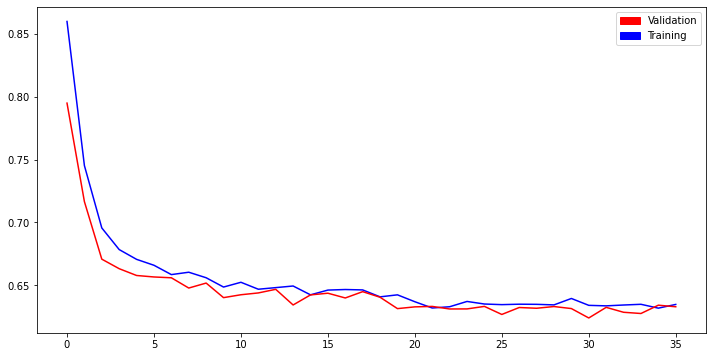

EPOCH 36 of 80
-- train loss 0.6318273184476075 -- valid loss 0.6321245813194443 --
-----run time 41651.06511902809sec -----
EPOCH 37 of 80
-- train loss 0.6358682761589686 -- valid loss 0.6385325912167045 --
-----run time 42693.959798812866sec -----
EPOCH 38 of 80
-- train loss 0.6371629807684157 -- valid loss 0.6332376857890802 --
-----run time 43780.21350502968sec -----
EPOCH 39 of 80
-- train loss 0.6320784031241028 -- valid loss 0.6327723330434631 --
-----run time 44911.018350601196sec -----
EPOCH 40 of 80
-- train loss 0.6366126280139994 -- valid loss 0.6361608663026024 --
-----run time 46074.690722465515sec -----
Train


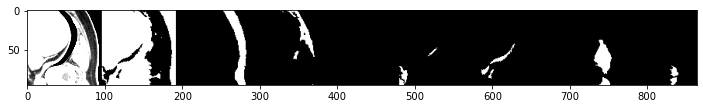

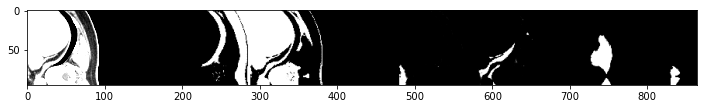

Valid


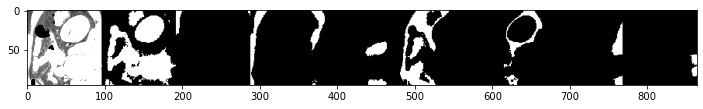

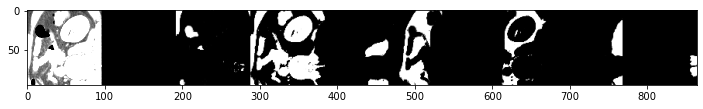

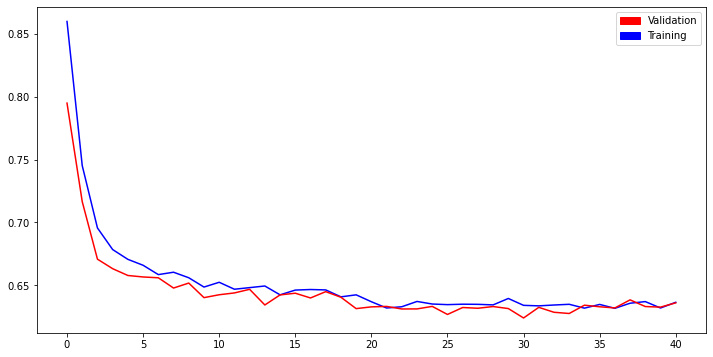

EPOCH 41 of 80
-- train loss 0.6345743006026303 -- valid loss 0.6188154764035169 --
-----run time 47141.708929777145sec -----
EPOCH 42 of 80
-- train loss 0.6282357818550534 -- valid loss 0.6246015201596653 --
-----run time 48307.55133652687sec -----
EPOCH 43 of 80
-- train loss 0.6343669620928941 -- valid loss 0.6287056970245698 --
-----run time 49437.779465675354sec -----
EPOCH 44 of 80
-- train loss 0.6277359062874759 -- valid loss 0.6323332830387003 --
-----run time 50508.46399450302sec -----
EPOCH 45 of 80
-- train loss 0.6287645161151886 -- valid loss 0.6253002640955588 --
-----run time 51639.6602640152sec -----
Train


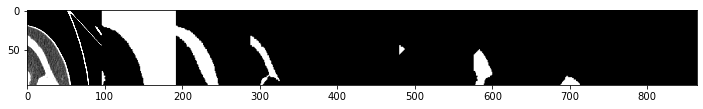

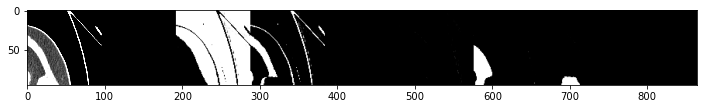

Valid


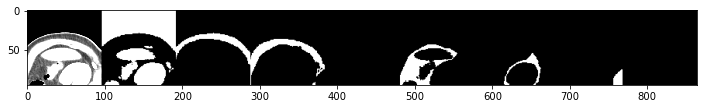

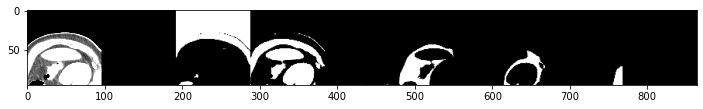

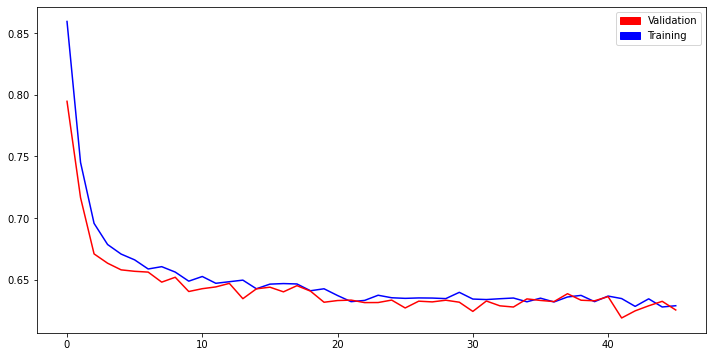

EPOCH 46 of 80
-- train loss 0.6330485062466727 -- valid loss 0.631792978328817 --
-----run time 52836.80676364899sec -----
EPOCH 47 of 80
-- train loss 0.6333721929126316 -- valid loss 0.6263344507007038 --
-----run time 54005.750890016556sec -----
EPOCH 48 of 80
-- train loss 0.633560488400636 -- valid loss 0.6382613199598649 --
-----run time 55160.560901641846sec -----
EPOCH 49 of 80
-- train loss 0.6291796643424917 -- valid loss 0.6345645811627892 --
-----run time 56244.6659078598sec -----
EPOCH 50 of 80
-- train loss 0.6340046474227199 -- valid loss 0.6297853045603808 --
-----run time 57449.955754995346sec -----
Train


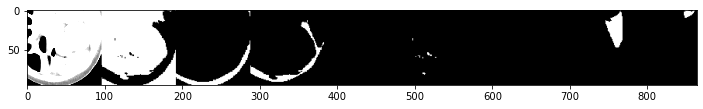

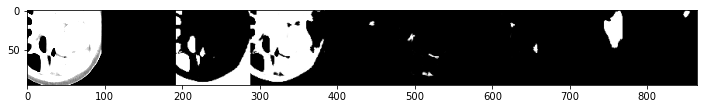

Valid


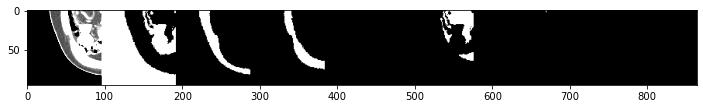

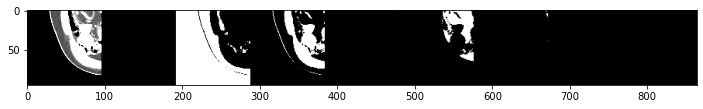

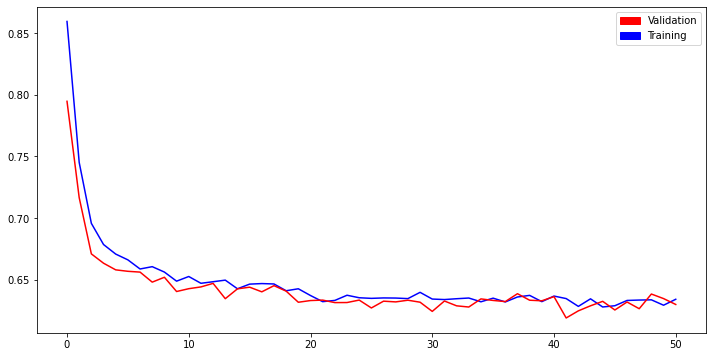

EPOCH 51 of 80
-- train loss 0.6354984605753863 -- valid loss 0.6316045908366933 --
-----run time 58581.49293065071sec -----
EPOCH 52 of 80
-- train loss 0.6369836821600243 -- valid loss 0.6329107722815346 --
-----run time 59708.58223772049sec -----
EPOCH 53 of 80
-- train loss 0.6323518577549193 -- valid loss 0.6271020388778519 --
-----run time 60791.62084674835sec -----
EPOCH 54 of 80
-- train loss 0.627242084896123 -- valid loss 0.6301254586261862 --
-----run time 61915.99264931679sec -----
EPOCH 55 of 80
-- train loss 0.6305496181602831 -- valid loss 0.6300830472918117 --
-----run time 62998.91268849373sec -----
Train


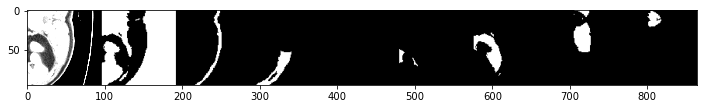

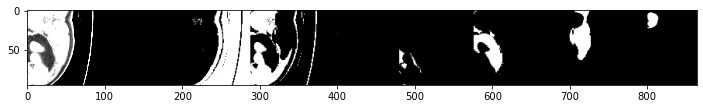

Valid


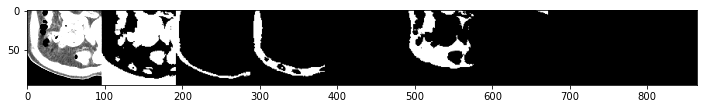

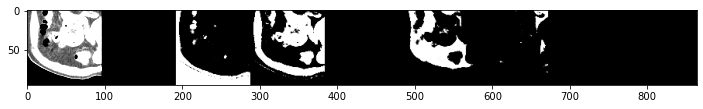

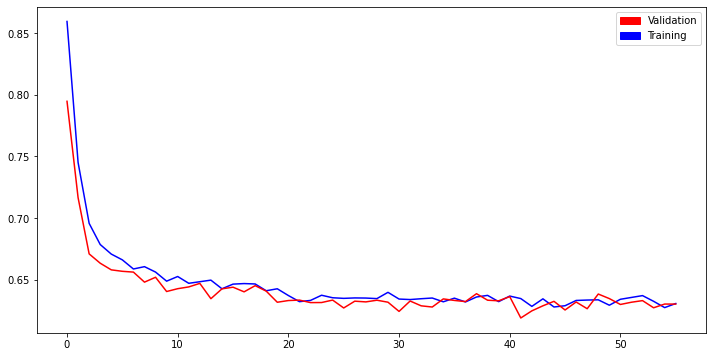

EPOCH 56 of 80
-- train loss 0.6297356122069888 -- valid loss 0.6219711557907217 --
-----run time 64207.21174144745sec -----
EPOCH 57 of 80
-- train loss 0.6348476725595968 -- valid loss 0.6371851190924644 --
-----run time 65335.90347123146sec -----
EPOCH 58 of 80
-- train loss 0.6299281986775221 -- valid loss 0.6268770352882498 --
-----run time 66416.60197973251sec -----
EPOCH 59 of 80
-- train loss 0.6343321157826318 -- valid loss 0.6364733866032433 --
-----run time 67446.73966145515sec -----
EPOCH 60 of 80
-- train loss 0.6307022287889763 -- valid loss 0.6313027476563173 --
-----run time 68575.98670983315sec -----
Train


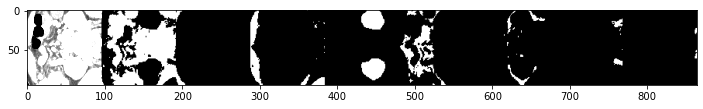

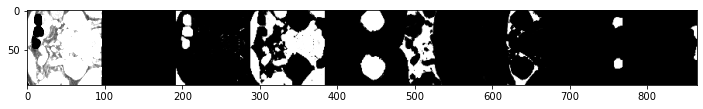

Valid


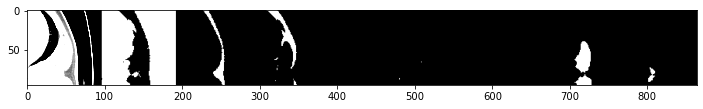

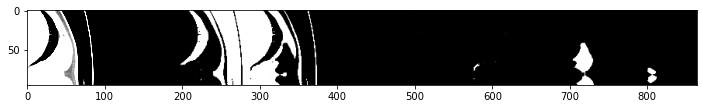

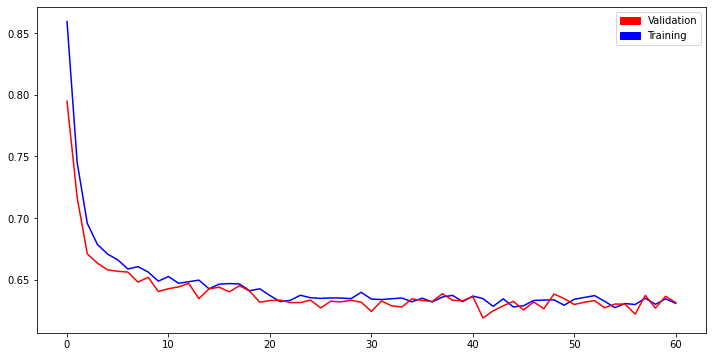

EPOCH 61 of 80
-- train loss 0.6304044164993144 -- valid loss 0.631105041679214 --
-----run time 69690.6687772274sec -----
EPOCH 62 of 80
-- train loss 0.6312318923296751 -- valid loss 0.6352923551903051 --
-----run time 70831.51139092445sec -----
EPOCH 63 of 80
-- train loss 0.6304210726861601 -- valid loss 0.6340348922154483 --
-----run time 71976.34212350845sec -----
EPOCH 64 of 80
-- train loss 0.6326357988295732 -- valid loss 0.6298422445269192 --
-----run time 73129.94531726837sec -----
EPOCH 65 of 80
-- train loss 0.6320694447667511 -- valid loss 0.6259936506257338 --
-----run time 74301.75205039978sec -----
Train


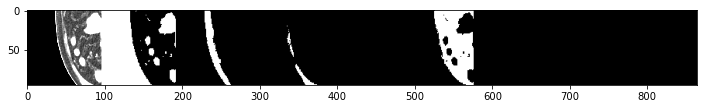

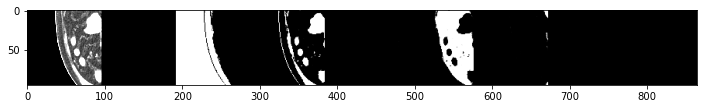

Valid


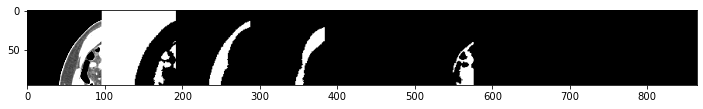

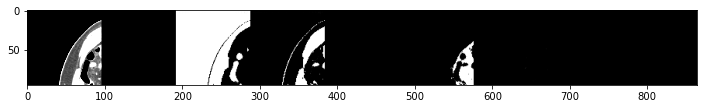

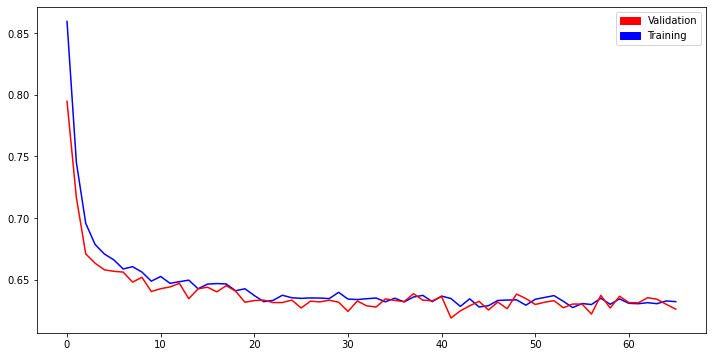

EPOCH 66 of 80
-- train loss 0.6286324594859724 -- valid loss 0.6219514231471455 --
-----run time 75351.87218761444sec -----
EPOCH 67 of 80
-- train loss 0.6324619387035016 -- valid loss 0.6285794096834519 --
-----run time 76441.28773236275sec -----
EPOCH 68 of 80
-- train loss 0.6328194983579495 -- valid loss 0.6287350900032941 --
-----run time 77552.93822836876sec -----
EPOCH 69 of 80
-- train loss 0.6326164603233337 -- valid loss 0.6263104361646316 --
-----run time 78816.98454475403sec -----
EPOCH 70 of 80
-- train loss 0.6337929512615557 -- valid loss 0.6315211373216966 --
-----run time 79994.43071913719sec -----
Train


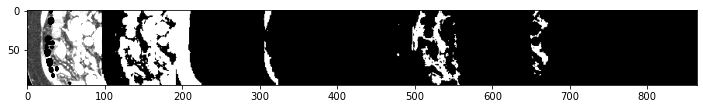

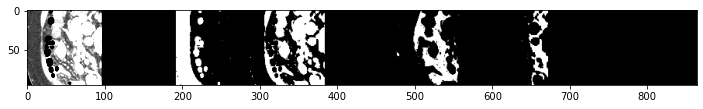

Valid


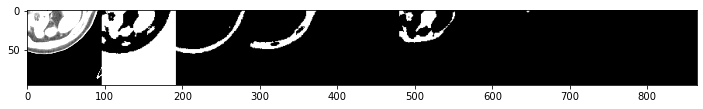

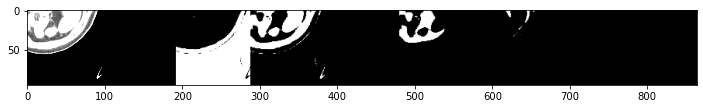

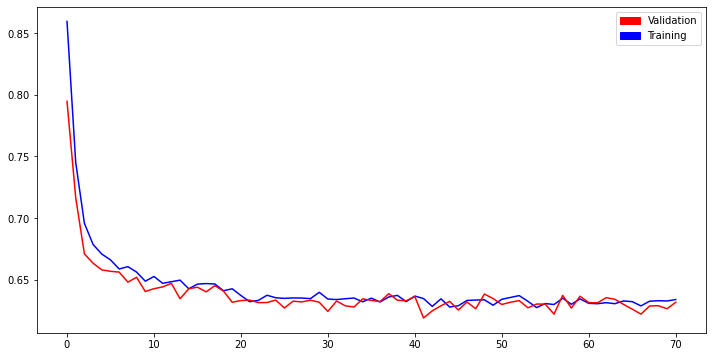

EPOCH 71 of 80
-- train loss 0.6336100303464466 -- valid loss 0.6290948557503083 --
-----run time 81080.81082510948sec -----
EPOCH 72 of 80
-- train loss 0.6324816702692597 -- valid loss 0.6265482810490272 --
-----run time 82318.59181642532sec -----
EPOCH 73 of 80
-- train loss 0.637079546628175 -- valid loss 0.6368212577174691 --
-----run time 83532.38995099068sec -----
EPOCH 74 of 80
-- train loss 0.6345159084708603 -- valid loss 0.6267309876925805 --
-----run time 84612.17751908302sec -----
EPOCH 75 of 80
-- train loss 0.6322703028166735 -- valid loss 0.6327435510123477 --
-----run time 85719.32803153992sec -----
Train


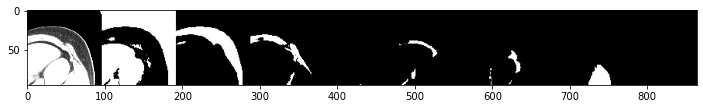

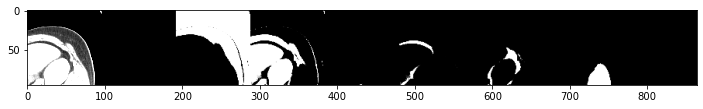

Valid


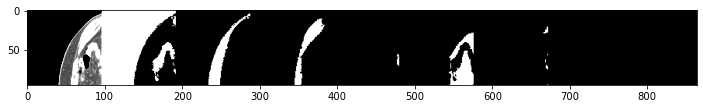

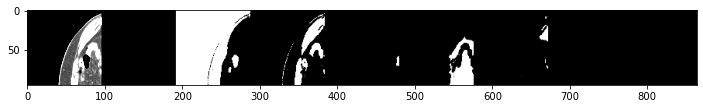

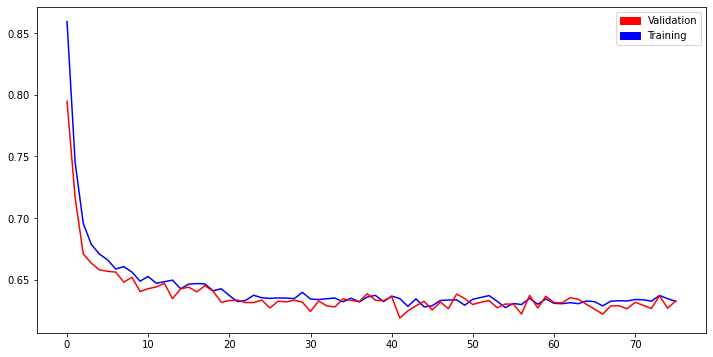

EPOCH 76 of 80
-- train loss 0.6354371977073175 -- valid loss 0.6279691931079415 --
-----run time 86830.05017971992sec -----
EPOCH 77 of 80
-- train loss 0.6327697530940727 -- valid loss 0.6405769954709446 --
-----run time 87945.79475688934sec -----
EPOCH 78 of 80
-- train loss 0.6314194875734823 -- valid loss 0.635820993605782 --
-----run time 88985.51472020149sec -----
EPOCH 79 of 80
-- train loss 0.6366137033259427 -- valid loss 0.6383424199679318 --
-----run time 90008.29583501816sec -----


In [20]:
#23.02.17 (2.1)_ Scheduler_gamma=0.1
train_losses = []
validation_losses = []
S = 50
save_path = '/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2.1)'
start_time = time.time()


print('STARTING TRAINING')

for i in range(num_epochs):
    train_loss, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    valid_loss, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('EPOCH {} of {}'.format(i, num_epochs))
    print('-- train loss {} -- valid loss {} --'.format(train_loss, valid_loss))
    print('-----run time {}sec -----'.format(time.time()-start_time))
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
        
    if i%5==0:
        
        print('Train')
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],
                                              train_input_lbl[1,:,:,S],train_input_lbl[2,:,:,S],
                                              train_input_lbl[3,:,:,S],train_input_lbl[4,:,:,S],train_input_lbl[5,:,:,S],
                                             train_input_lbl[6,:,:,S],train_input_lbl[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()
        
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],
                                              train_seg_part[1,:,:,S],train_seg_part[2,:,:,S],
                                              train_seg_part[3,:,:,S],train_seg_part[4,:,:,S],train_seg_part[5,:,:,S],
                                             train_seg_part[6,:,:,S],train_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.show()
        
        print('Valid')
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],
                                              valid_input_lbl_part[1,:,:,S],valid_input_lbl_part[2,:,:,S],
                                              valid_input_lbl_part[3,:,:,S],valid_input_lbl_part[4,:,:,S],valid_input_lbl_part[5,:,:,S],
                                             valid_input_lbl_part[6,:,:,S],valid_input_lbl_part[7,:,:,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.show()  
        plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],
                                              valid_output_seg_part[1,:,:,S],valid_output_seg_part[2,:,:,S],
                                              valid_output_seg_part[3,:,:,S],valid_output_seg_part[4,:,:,S],valid_output_seg_part[5,:,:,S],
                                             valid_output_seg_part[6,:,:,S],valid_output_seg_part[7,:,:,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        
        plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()
        
        #torch.save(net_seg,'vnet_ct_training_epoch='+str(i))
    path = os.path.join(save_path, 'vnet_ct_training_epoch='+str(i))
    torch.save(net_seg,path)
    scheduler.step()

# Test

In [26]:
# Test dataset - SubjectDataset
#import natsort
#import nibabel as nib
image_paths=[]
label_paths=[]

images_dir = '/home/minyoung/SEGMENTATION/23.02.04/Test/images'
labels_dir = '/home/minyoung/SEGMENTATION/23.02.04/Test/RE_labels'

img_list = natsort.natsorted(os.listdir(images_dir))
lb_list = natsort.natsorted(os.listdir(labels_dir))

num = len(img_list)

for i in range(0, num):
    image_paths.append(os.path.join(images_dir, img_list[i]))
    label_paths.append(os.path.join(labels_dir, lb_list[i]))
    
# image_paths = natsort.natsorted(os.listdir(images_dir))
# label_paths = natsort.natsorted(os.listdir(labels_dir))

assert len(image_paths)==len(label_paths)

subjects=[]
for (image_path, label_path) in zip(image_paths, label_paths):
#     image_path = images_dir+'/'+image_path
#     label_path = labels_dir+'/'+label_path
    subject = tio.Subject(
                img = tio.ScalarImage(image_path),
                label = tio.LabelMap(label_path))
    subjects.append(subject)
test_dataset=tio.SubjectsDataset(subjects)
print('Dataset size : ', len(test_dataset), 'subjects')

Dataset size :  20 subjects


In [30]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2)/vnet_ct_training_epoch=79')

In [27]:
# test data transform
test_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
    tio.OneHot(),
])

test_set = tio.SubjectsDataset(
    test_dataset, transform=test_transform)

(1, 239, 179, 296) (1, 239, 179, 296) (1, 239, 179, 296)
(239, 179, 296, 1) (239, 179, 296, 1) (239, 179, 296, 1)


<Figure size 864x432 with 0 Axes>

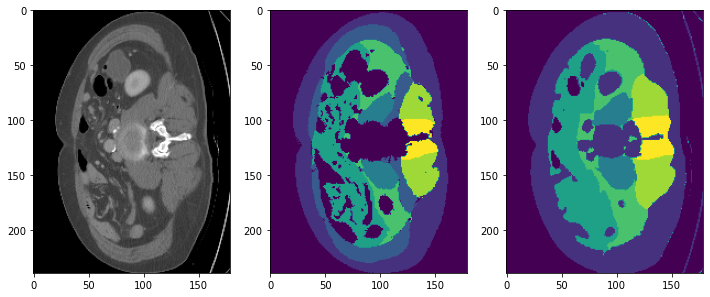

<Figure size 864x432 with 0 Axes>

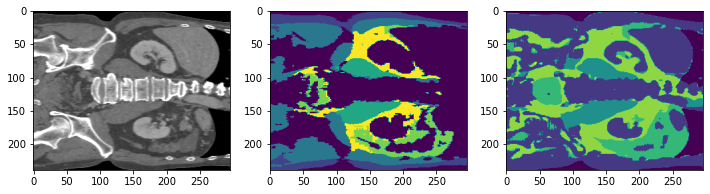

In [32]:
import nibabel as nib
A=0
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

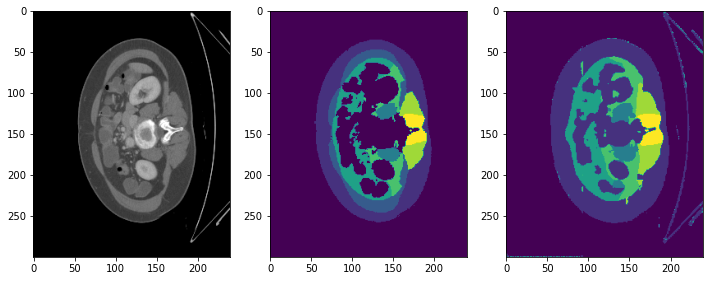

<Figure size 864x432 with 0 Axes>

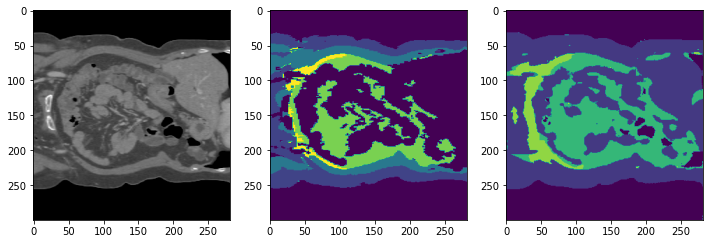

In [33]:
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

In [27]:
label = subject['label'].data
print(label.shape)

torch.Size([8, 239, 179, 296])


torch.Size([239, 179, 296])


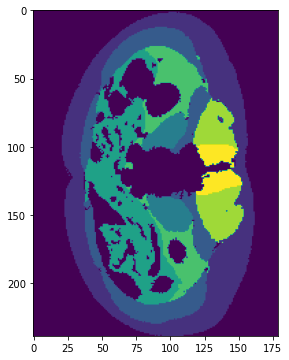

In [29]:
#foreground_cat = np.argmax(foreground, axis=0)
label_argmax = np.argmax(label, axis=0)
print(label_argmax.shape)
plt.imshow(label_argmax[:,:,150])
plt.show()

In [34]:
label.shape

torch.Size([8, 300, 240, 282])

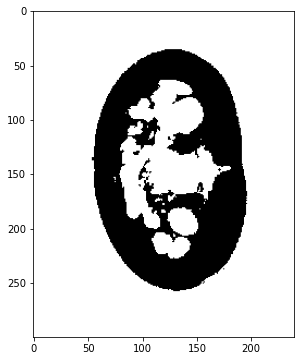

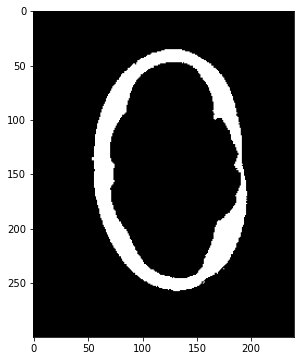

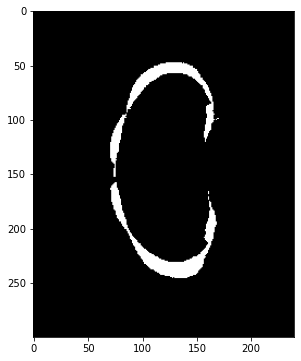

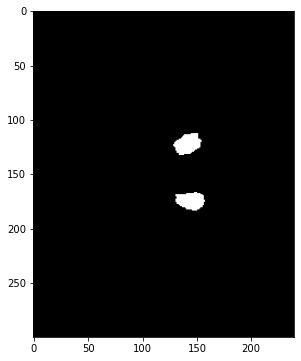

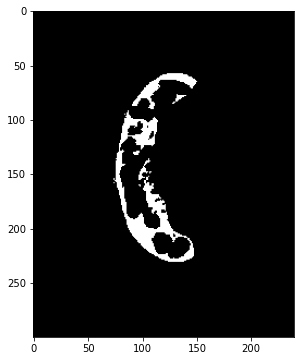

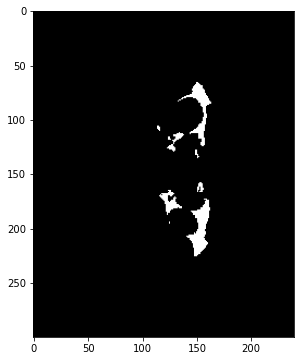

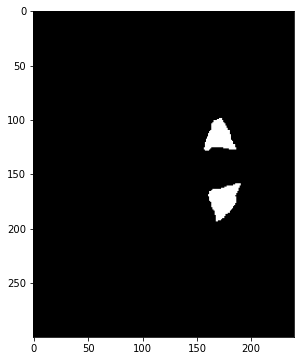

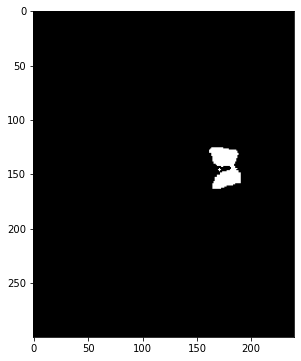

In [35]:
for i in range(label.shape[0]):
    plt.imshow(label[i,:,:,150], cmap='gray')
    plt.show()

### TEST (2.1)

In [22]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.16/23.02.17(2.1)/vnet_ct_training_epoch=79')

In [24]:
# test data transform
test_transform = tio.Compose([
    tio.Resample(1.5),
    tio.Crop((10,10,50,30,10,10)),
    tio.Clamp(-300,500),
    tio.ZNormalization(),
    tio.OneHot(),
])

test_set = tio.SubjectsDataset(
    test_dataset, transform=test_transform)

NameError: name 'test_dataset' is not defined

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

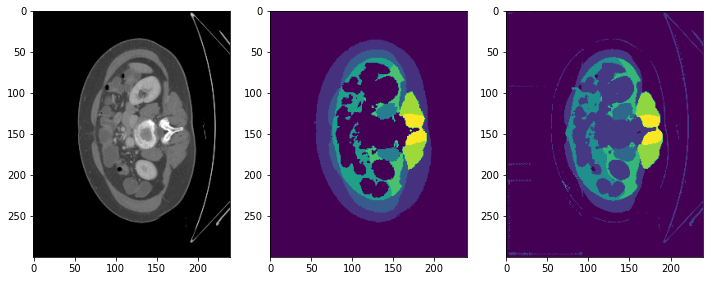

<Figure size 864x432 with 0 Axes>

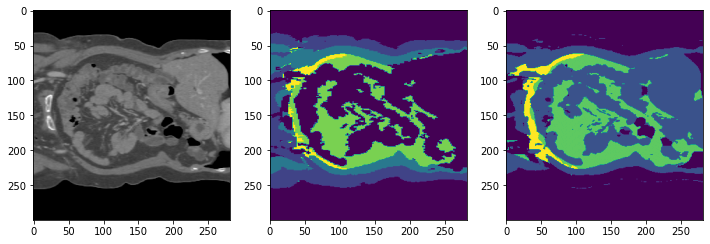

In [24]:
import nibabel as nib
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.16/test/(2.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0])
arr[2].imshow(prediction[:,:,Z,0])

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0])
arr2[2].imshow(prediction[:,Y,:,0])

<Figure size 864x432 with 0 Axes>

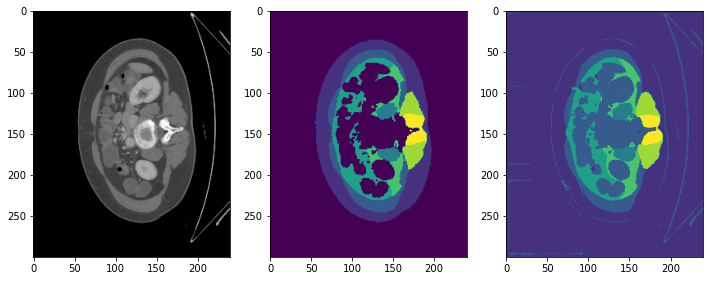

<Figure size 864x432 with 0 Axes>

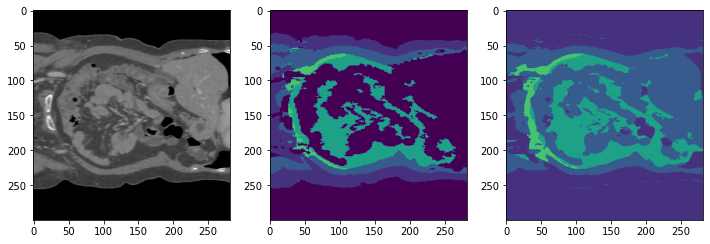

In [26]:
# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7 )
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)

## 2.1.1 Test

In [23]:
# model load
model=torch.load('/home/minyoung/SEGMENTATION/23.02.22/model_backup/02.24(2.1.1)/vnet_epoch=79')

(1, 300, 240, 282) (1, 300, 240, 282) (1, 300, 240, 282)
(300, 240, 282, 1) (300, 240, 282, 1) (300, 240, 282, 1)


<Figure size 864x432 with 0 Axes>

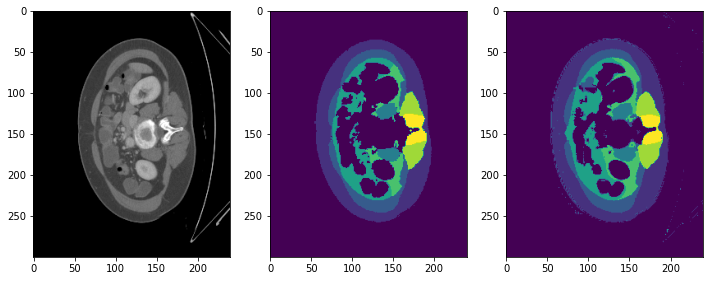

<Figure size 864x432 with 0 Axes>

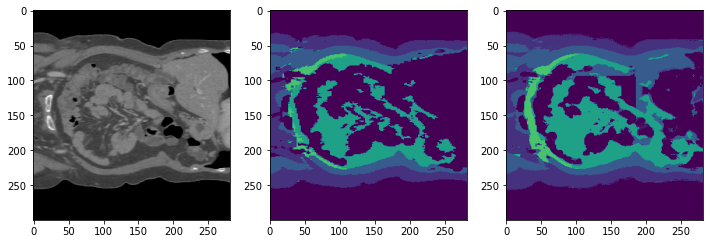

In [28]:
import nibabel as nib
A=10
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.22/test/(2.1.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7)
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)

(1, 239, 179, 296) (1, 239, 179, 296) (1, 239, 179, 296)
(239, 179, 296, 1) (239, 179, 296, 1) (239, 179, 296, 1)


<Figure size 864x432 with 0 Axes>

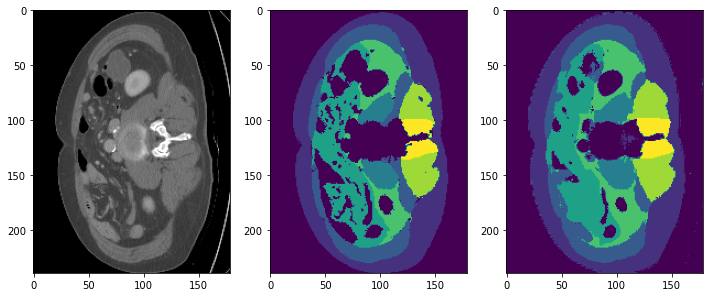

<Figure size 864x432 with 0 Axes>

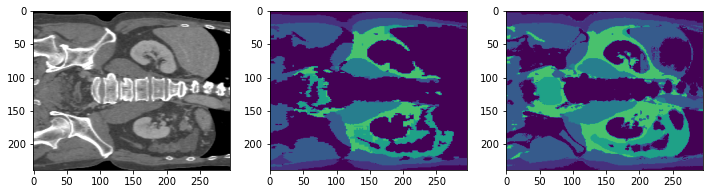

In [29]:
#import nibabel as nib
A=0
device=torch.device('cuda')

# patch to 1 volume image
subject = test_set[A]
patch_size = 96  
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['img'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=1)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
foreground_cat = np.argmax(foreground, axis=0)
#foreground_fix = fix_class(foreground_cat)
foreground_fix=foreground_cat[np.newaxis,:,:,:]
affine = subject['img'].affine
prediction = tio.ScalarImage(tensor=foreground_fix, affine=affine)
subject.add_image(prediction, 'prediction')
#subject.plot(figsize=(9, 8))

####################################################

# Save to nifti file
prediction = subject['prediction'].data
CTimg = subject['img'].data
label = subject['label'].data
# onehot > one image
label_arg = np.argmax(label, axis=0)
label_arg=label_arg[np.newaxis,:,:,:]

# label[label==7]=2
# label[label==8]=2
#label[label==6]=1
# label[label==5]=4

save_path = '/home/minyoung/SEGMENTATION/23.02.22/test/(2.1.1)'

prediction = prediction.numpy().astype(np.float64)
CTimg = CTimg.numpy().astype(np.float64)
label_arg = label_arg.numpy().astype(np.float64)

print(prediction.shape, CTimg.shape, label_arg.shape)
#input_seg = np.reshape(train_input_lbl,(1,256,256,120))

prediction = np.transpose(prediction,[1,2,3,0])
CTimg = np.transpose(CTimg,[1,2,3,0])
label_arg = np.transpose(label_arg,[1,2,3,0])

print(prediction.shape, CTimg.shape, label_arg.shape)

prediction_save = nib.Nifti1Image(prediction, affine=subject['prediction'].affine)
CTimg_save = nib.Nifti1Image(CTimg, affine=subject['img'].affine)
label_save = nib.Nifti1Image(label_arg, affine=subject['label'].affine)
#new_seg.header['pixdim']=[1., 2,2,3,1.,1.,1.,1.]
nib.save(prediction_save,os.path.join(save_path,'prediction_'+str(A)+'.nii.gz'))
nib.save(CTimg_save,os.path.join(save_path,'origin_'+str(A)+'.nii.gz'))
nib.save(label_save,os.path.join(save_path,'label_'+str(A)+'.nii.gz'))

######################################################

# Plot
Z=150; Y=100
plt.figure()
f, arr = plt.subplots(1,3)
arr[0].imshow(CTimg[:,:,Z,0], cmap='gray')
arr[1].imshow(label_arg[:,:,Z,0],vmin=0,vmax=7)
arr[2].imshow(prediction[:,:,Z,0],vmin=0,vmax=7)

plt.figure()
f2, arr2 = plt.subplots(1,3)
arr2[0].imshow(CTimg[:,Y,:,0], cmap='gray')
arr2[1].imshow(label_arg[:,Y,:,0],vmin=0,vmax=7)
arr2[2].imshow(prediction[:,Y,:,0],vmin=0,vmax=7)